# Предсказание стоимости автомобиля Ford по его VIN-коду

<font size="4"><b>Описание исследования</b></font>

В ходе данного проекта необходимо по минимально доступному набору данных (VIN-код) построить прогнозную модель.


<font size="4"><b>Цель проекта</b></font>

С помощью машинного обучения необходимо наилучшим образом предсказывать стоимость автомобиля.

<font size="4"><b>Задачи исследования</b></font>

- Из VIN-кода необходимо извлечь характеристики автомобиля с помощью модуля re;
- Сформировать датафрейм со входными признаками;
- Разработать модель машинного обучения для предсказания цены автомобиля Ford.


<font size="4"><b>Исходные данные</b></font>

В наличии txt-файл с данными. Для каждого автомобиля имеется VIN-код и цена.

## Загрузка данных

In [11]:
# импорт библиотек
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import shap

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV

# загружаем необходимые инструменты
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# загружаем классы для преобразования данных
from sklearn.preprocessing import OneHotEncoder

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import mean_squared_error as mse

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv

In [12]:
# настройка графиков

# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'axes.titleweight': 'bold',
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)
plt.style.use('seaborn-bright')

<ipython-input-12-49c721a9230d>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


In [13]:
# задание константных значений
RANDOM_STATE = 123456
TEST_SIZE = 0.25

In [14]:
with open ('/content/sample_data/vin_ford_train.txt', 'r') as f:
  example = f.read()

example[:55]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дя'

## Структура VIN-кода

В наличии информация по северо-американским VIN-кодам автомобилей Ford.

Основные характеристики VIN-кода:

- состоит из 17 символов
- на первых 14 позициях могут быть как цифры, так и латинские буквы кроме I, O и Q,
- на 15-17 позициях всегда цифры.
- в кодировке года не используются символы 'U', 'Z' и '0' (ноль).

Таким образом, американский VIN-код состоит из закодированной информации о (по порядку):
- 1-3 - WMI (World manufacturer identifier) - Идентификатор мирового производителя;
- 4 - brake system - тормозная система;
- 5-7 - используемая автомобильная платформа, модель и тип кузова;
- 8 - engine code - тип двигателя;
- 9 - check digit - проверочное значение;
- 10 - год выпуска;
- 11 - завод-производитель;
- 12-17 - serial_num (serial number) - идентификатор конкретного транспортного средства.

Создадим список возможных символов, которые могут присутствовать в VIN-коде.

In [15]:
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_NUMS = [str(x) for x in range(1, 10)] + ['0']

allowed = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
allowed_year = re.sub('["U"|"Z"|"0"]', '', allowed)
print(f'Разрешенные символы {allowed}\n\
Разрешенные символы для кодировки года {allowed_year}')

Разрешенные символы ABCDEFGHJKLMNPRSTUVWXYZ1234567890
Разрешенные символы для кодировки года ABCDEFGHJKLMNPRSTVWXY123456789


In [16]:
# структура vin-кода по символам
wmi = f'(?P<wmi>[{allowed}]{{3}})'                 # 1-3
brake = f'(?P<brake>[{allowed}])'                    # 4
model = f'(?P<model>[{allowed}]{{3}})'               # 5-7
engine = f'(?P<engine>[{allowed}])'                   # 8
check = f'(?P<check>[{allowed}])'                    # 9
year = f'(?P<year>[{allowed_year}])'                # 10
plant = f'(?P<plant>[{allowed}])'                    # 11
serial_num = f'(?P<serial_num>[{allowed}]{{3}}\\d{{3}})'   # 12-17

# извлечение цены
price = f'(?P<price>\\d+)'

В исходном текстовом файле для каждого автомобиля дан VIN-код и через двоеточие от него его цена. Распишем эту структуру и сформируем датафрейм с извлеченными данными.

In [17]:
# соберем всю структуру имеющихся данных
vin_and_price = f'{wmi}{brake}{model}{engine}{check}{year}{plant}{serial_num}:{price}'
sample_re = re.compile(vin_and_price)

# формирование датафрейма с данными
car_data = pd.DataFrame([x.groupdict() for x in sample_re.finditer(example)])
car_data.sample(5)

,wmi,brake,model,engine,check,year,plant,serial_num,price
51982,1FA,D,P3F,2,6,E,L,151413,12300
39040,1FA,H,P2E,8,X,D,G,184066,16500
14253,1FT,R,W12,W,4,6,F,B81090,11200
18541,1FT,N,X21,S,6,3,E,B27890,3000
61727,3FA,6,P0H,9,5,E,R,279354,17700


In [18]:
# получение общей информации о датафрейме
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wmi         71884 non-null  object
 1   brake       71884 non-null  object
 2   model       71884 non-null  object
 3   engine      71884 non-null  object
 4   check       71884 non-null  object
 5   year        71884 non-null  object
 6   plant       71884 non-null  object
 7   serial_num  71884 non-null  object
 8   price       71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


<font size="4"><b>Выводы по первоначальному обзору данных датафрейма car_data</b></font>

- Датафрейм был создан из текстового формата. Характеристики автомобиля были извлечены из VIN-кода с помощью модуля re.
- В полученном датафрейме 71884 строк и 9 столбцов.
- Пропусков нет.
- Столбцец `price` с ценой автомобиля необходимо преобразовать в численный формат.

In [19]:
# перевод данных в столбце `price` к числовому типу
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')

In [20]:
# проверка дубликатов
car_data.duplicated().sum()

0

## Исследовательский анализ данных

In [21]:
# функция, которая выводит описательную статистику для количественного признака
# строит гистограмму распределения и
# диаграмму размаха

def build_hist_num_feature(data, b, feature_name):
    # входные данные: data - нужный датафрейм
    # feature - название столбца с количественным признаком,
    # b - количество бинов для гистограммы,
    # feature_name - название признака

    print(f'Статистика для {feature_name}\n\n {data.describe()}')

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    ax1.set_title('Гистограмма распределения')
    ax1.set_ylabel('Частота')
    ax1.grid(True)
    data.plot(kind='hist', bins=b, ax=ax1)


    data.plot(kind='box', ax=ax2, vert=False)
    ax2.set_xlabel(feature_name)
    ax2.set_title('Разброс значений признака')
    plt.suptitle(feature_name)
    plt.show()

Статистика для Цена, $

 count    71884.000000
mean     14321.449377
std       7827.057238
min       1000.000000
25%       8800.000000
50%      13500.000000
75%      19500.000000
max      36500.000000
Name: price, dtype: float64


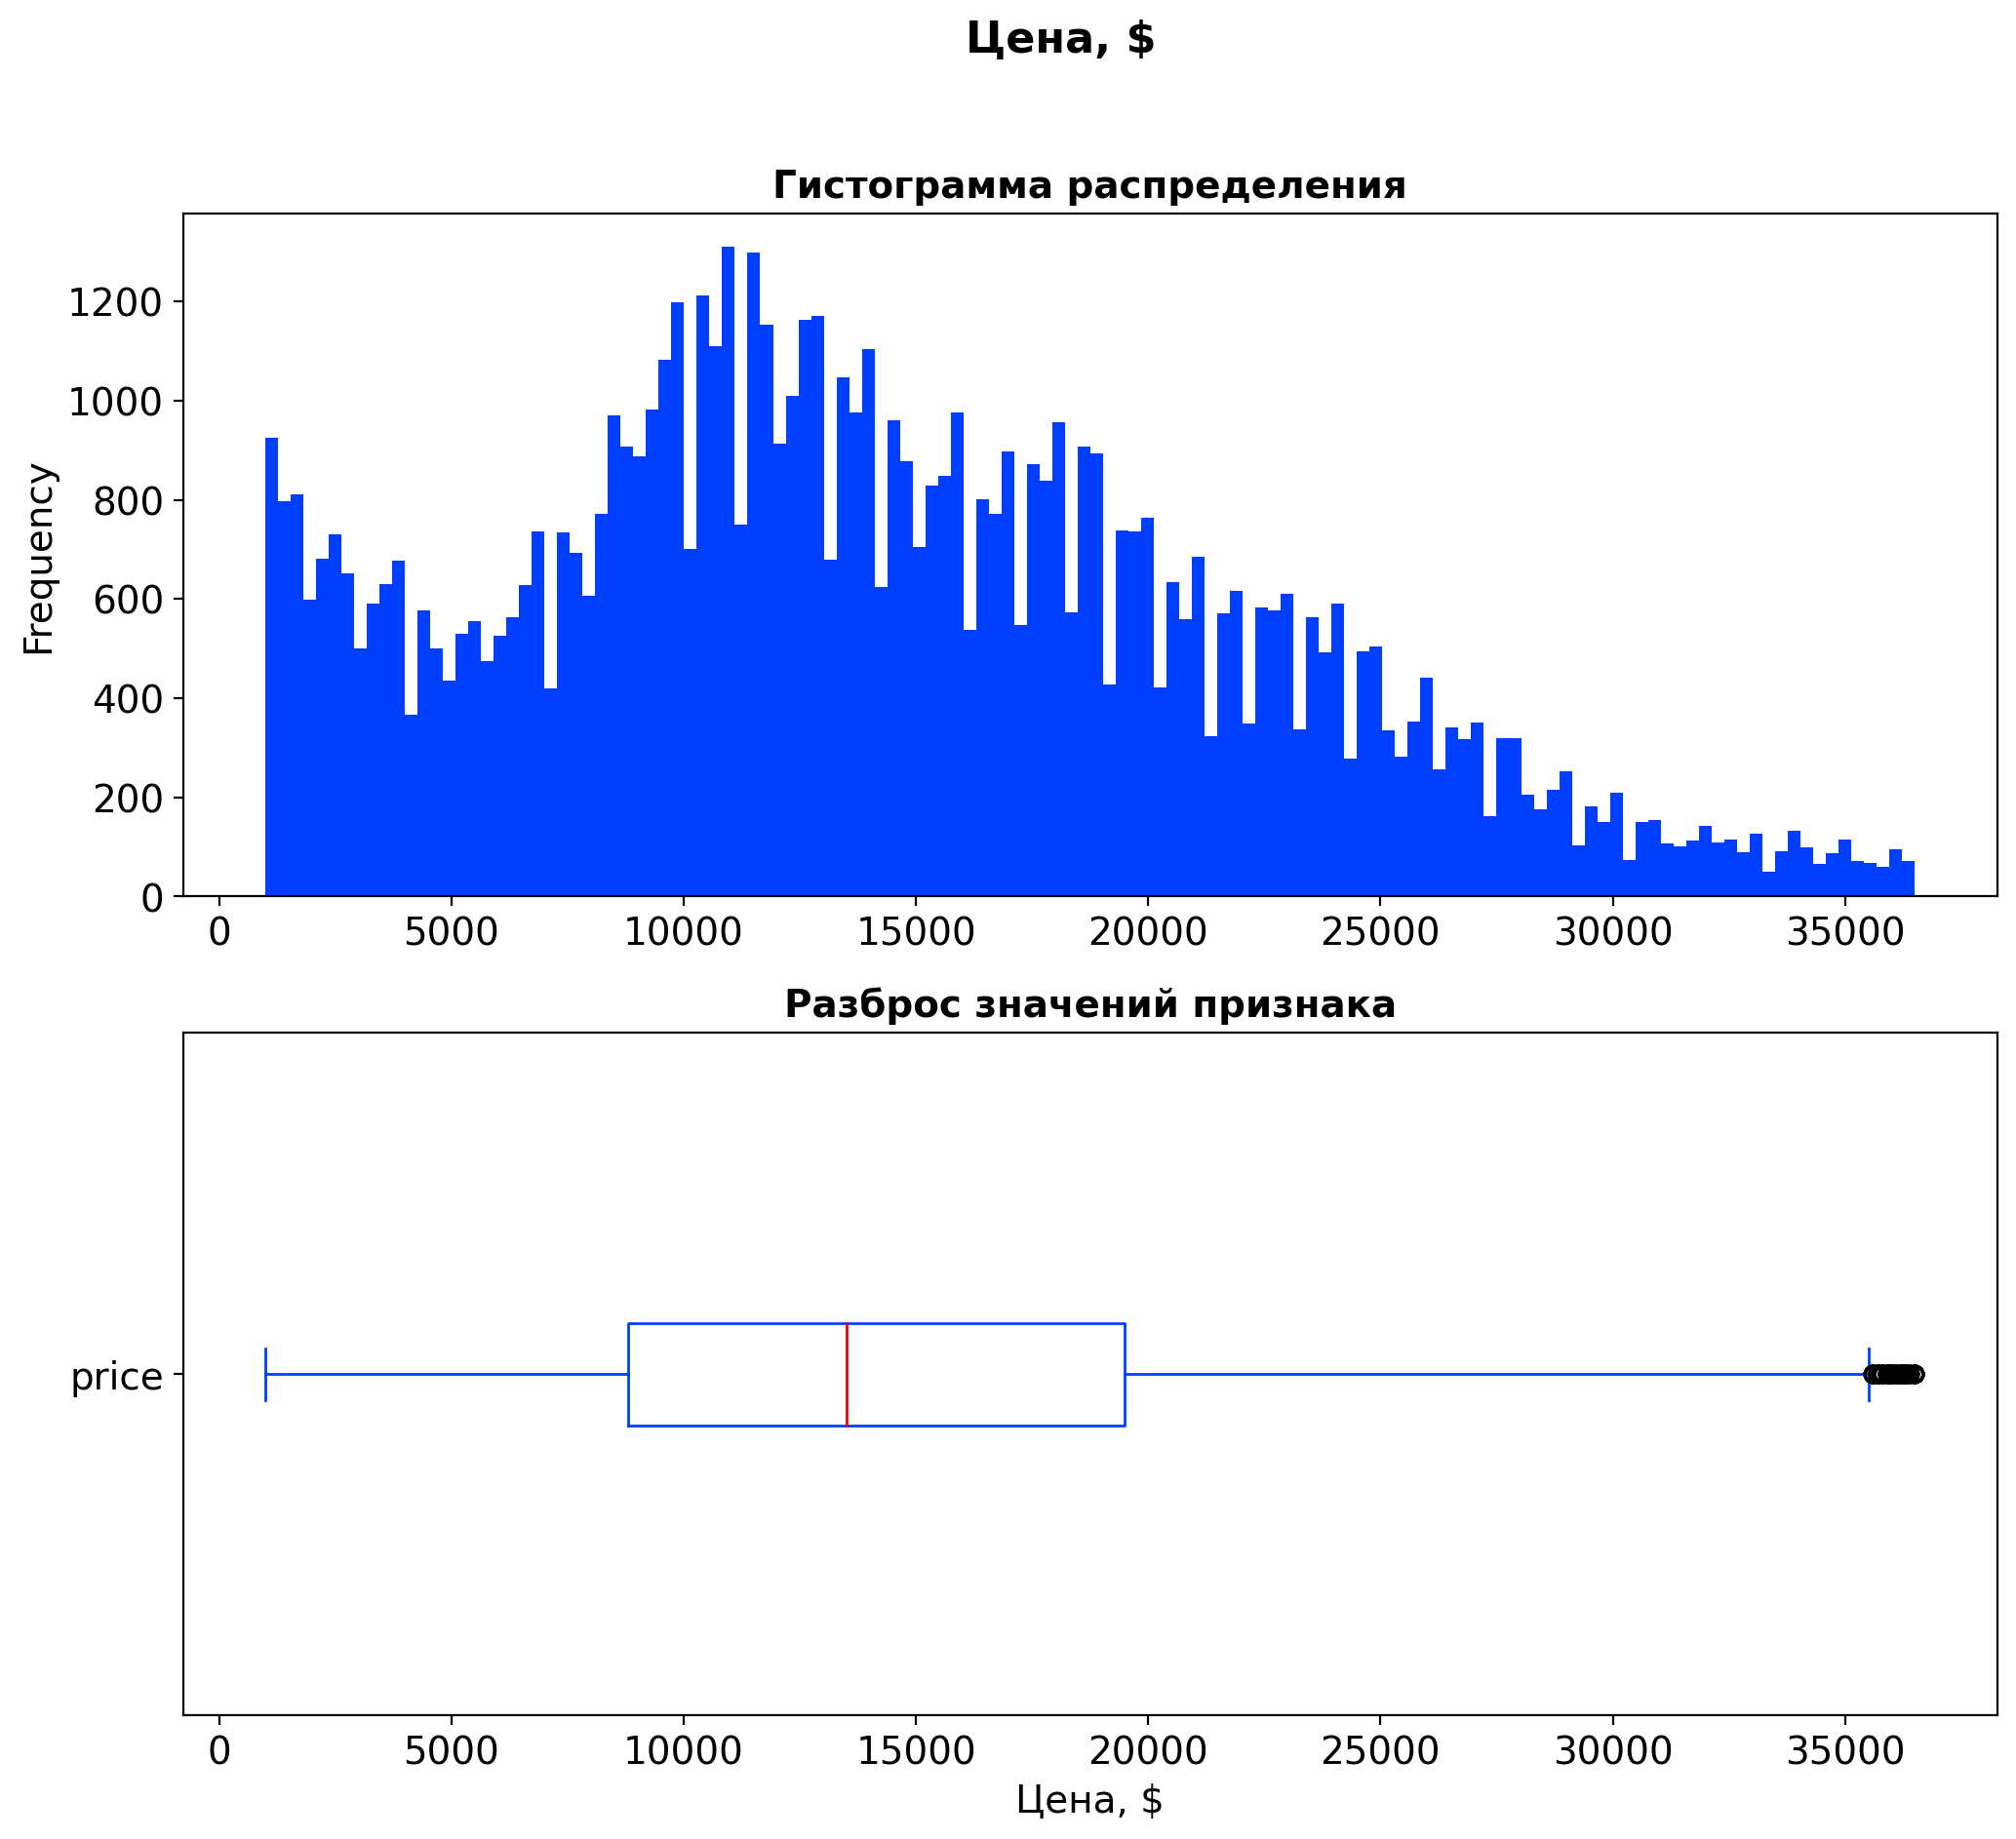

In [22]:
# вызов функции для построения гистограммы и боксплота
build_hist_num_feature(car_data['price'], 130, 'Цена, $')

In [23]:
# расчет значений верхнего "уса" на диаграмме размаха
q3, q1 = np.percentile (car_data['price'], [75 ,25])
iqr = q3 - q1
upper = q3 + 1.5 * iqr

print(f'Верхняя граница {upper}')

Верхняя граница 35550.0


По гистограмме и боксплоту видно, что в выборке 50% всех автомобилей имеет цену от 8800 до 19500. Медиана равна 13500.

Также в выборке присутствует группа недорогих автомобилей до 5000. Минимальная цена автомобиля в выборке 1000.

Среднее значение смещено в сторону правого "хвоста" и равно 14321. Также присутствует небольшое количество дорогих авто, стоимость которых выбивается за верхний "ус" диаграммы размаха - это автомобили дороже 35550. Оставим их в датасете для предсказания дорогих автомобилей.

In [24]:
# функция для построения горизонтальной столбчатой диаграммы для дискретного признака
# получение уникальных значений в столбце методом value_counts()
# преобразование полученного объекта Series в датафрейм методом to_frame()
# построение гистограммы методом plot() с типом kind='barh'

def disc_plot(feature, title, ylabel):
    # входные данные:
    # feature - название столбца с количественным признаком,
    # title - название признака для заголовка
    # xlabel - подпись оси


    car_data[feature] \
            .value_counts(ascending=True) \
            .to_frame() \
            .plot(y='count', kind='barh',
                  legend=False, figsize=(7, 7))

    plt.title(title)
    plt.ylabel(ylabel)

    # добавим метки для каждого столбца
    for index, value in enumerate(car_data[feature].value_counts(ascending=True)):
        plt.text(value, index, str(value), ha='left', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

In [25]:
# функция для построения диаграммы размаха цены в зависимости от категориального признака
def build_boxplot(title, feature):

    car_data.boxplot(column='price', by=feature, figsize=(12, 5))
    plt.title('Диаграмма размаха цены в зависимости от признака '+title)
    plt.xlabel(title)
    plt.ylabel('Цена, $', fontsize=14)
    plt.tight_layout()
    plt.show()

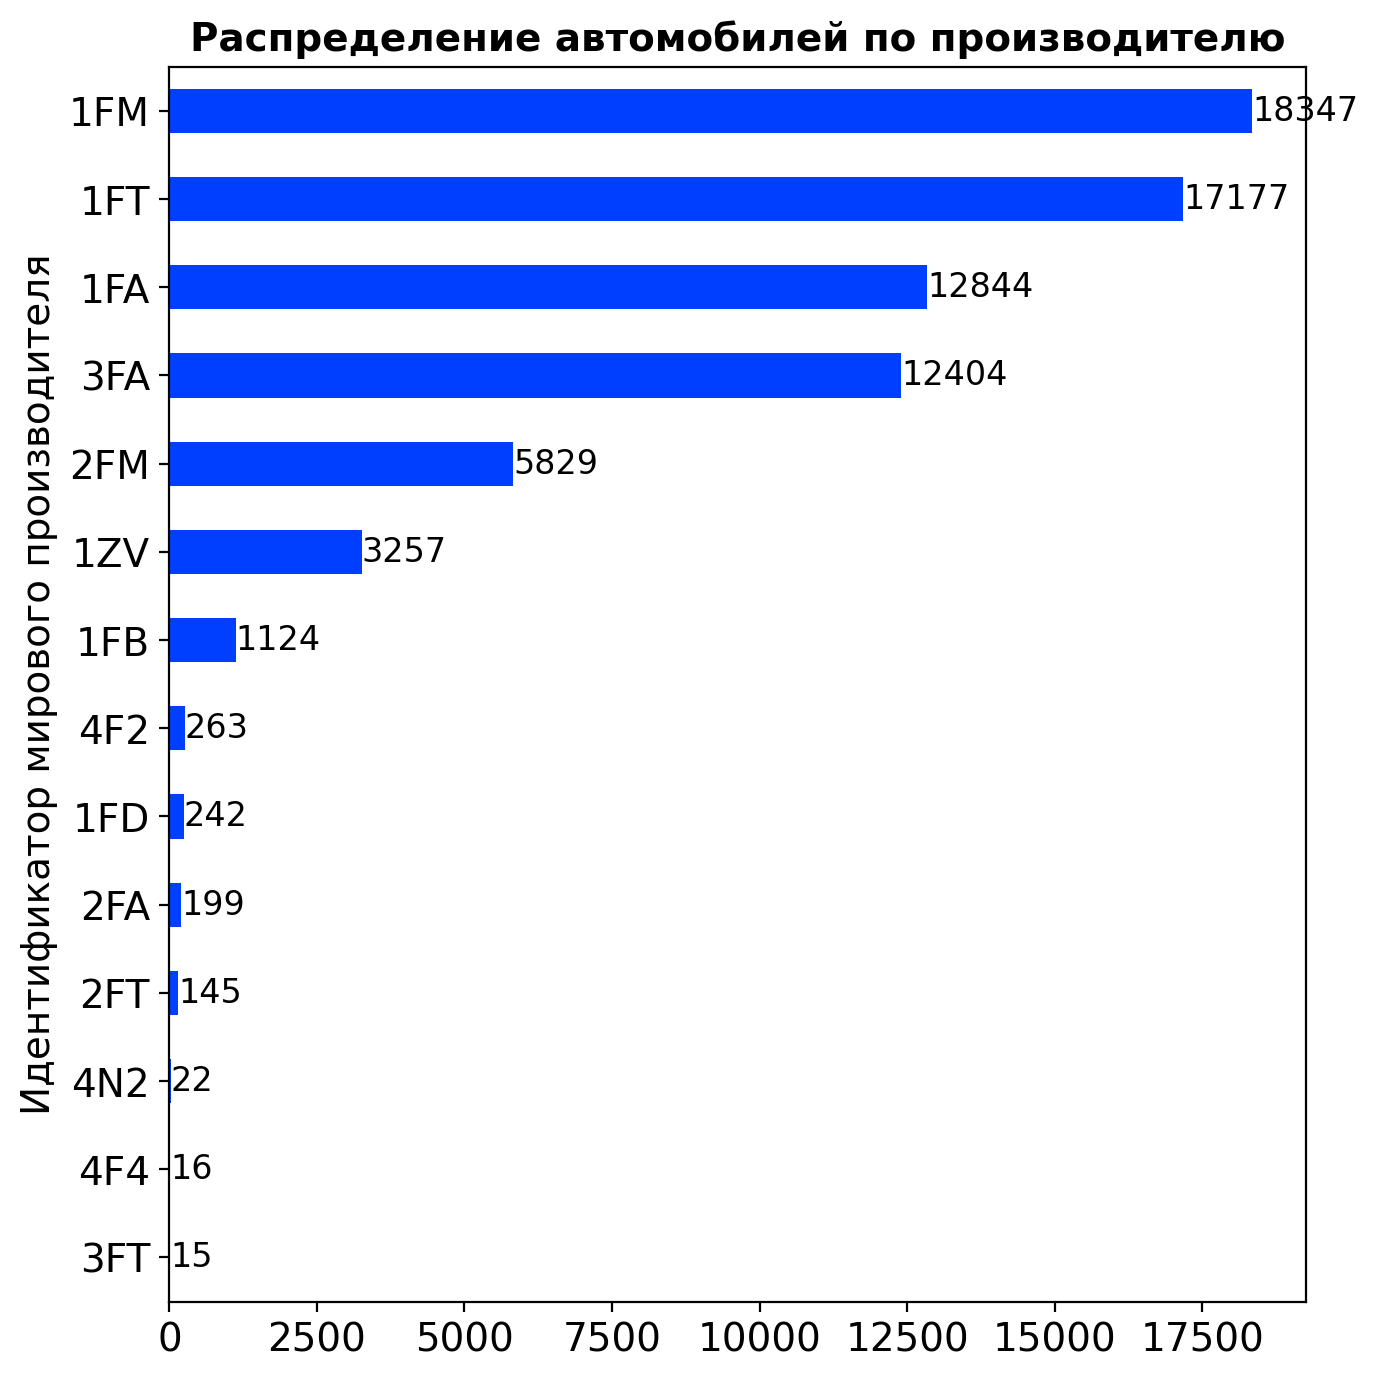

In [26]:
# вызов функции для построения горизонтальной столбчатой диаграммы
disc_plot('wmi', 'Распределение автомобилей по производителю', 'Идентификатор мирового производителя')

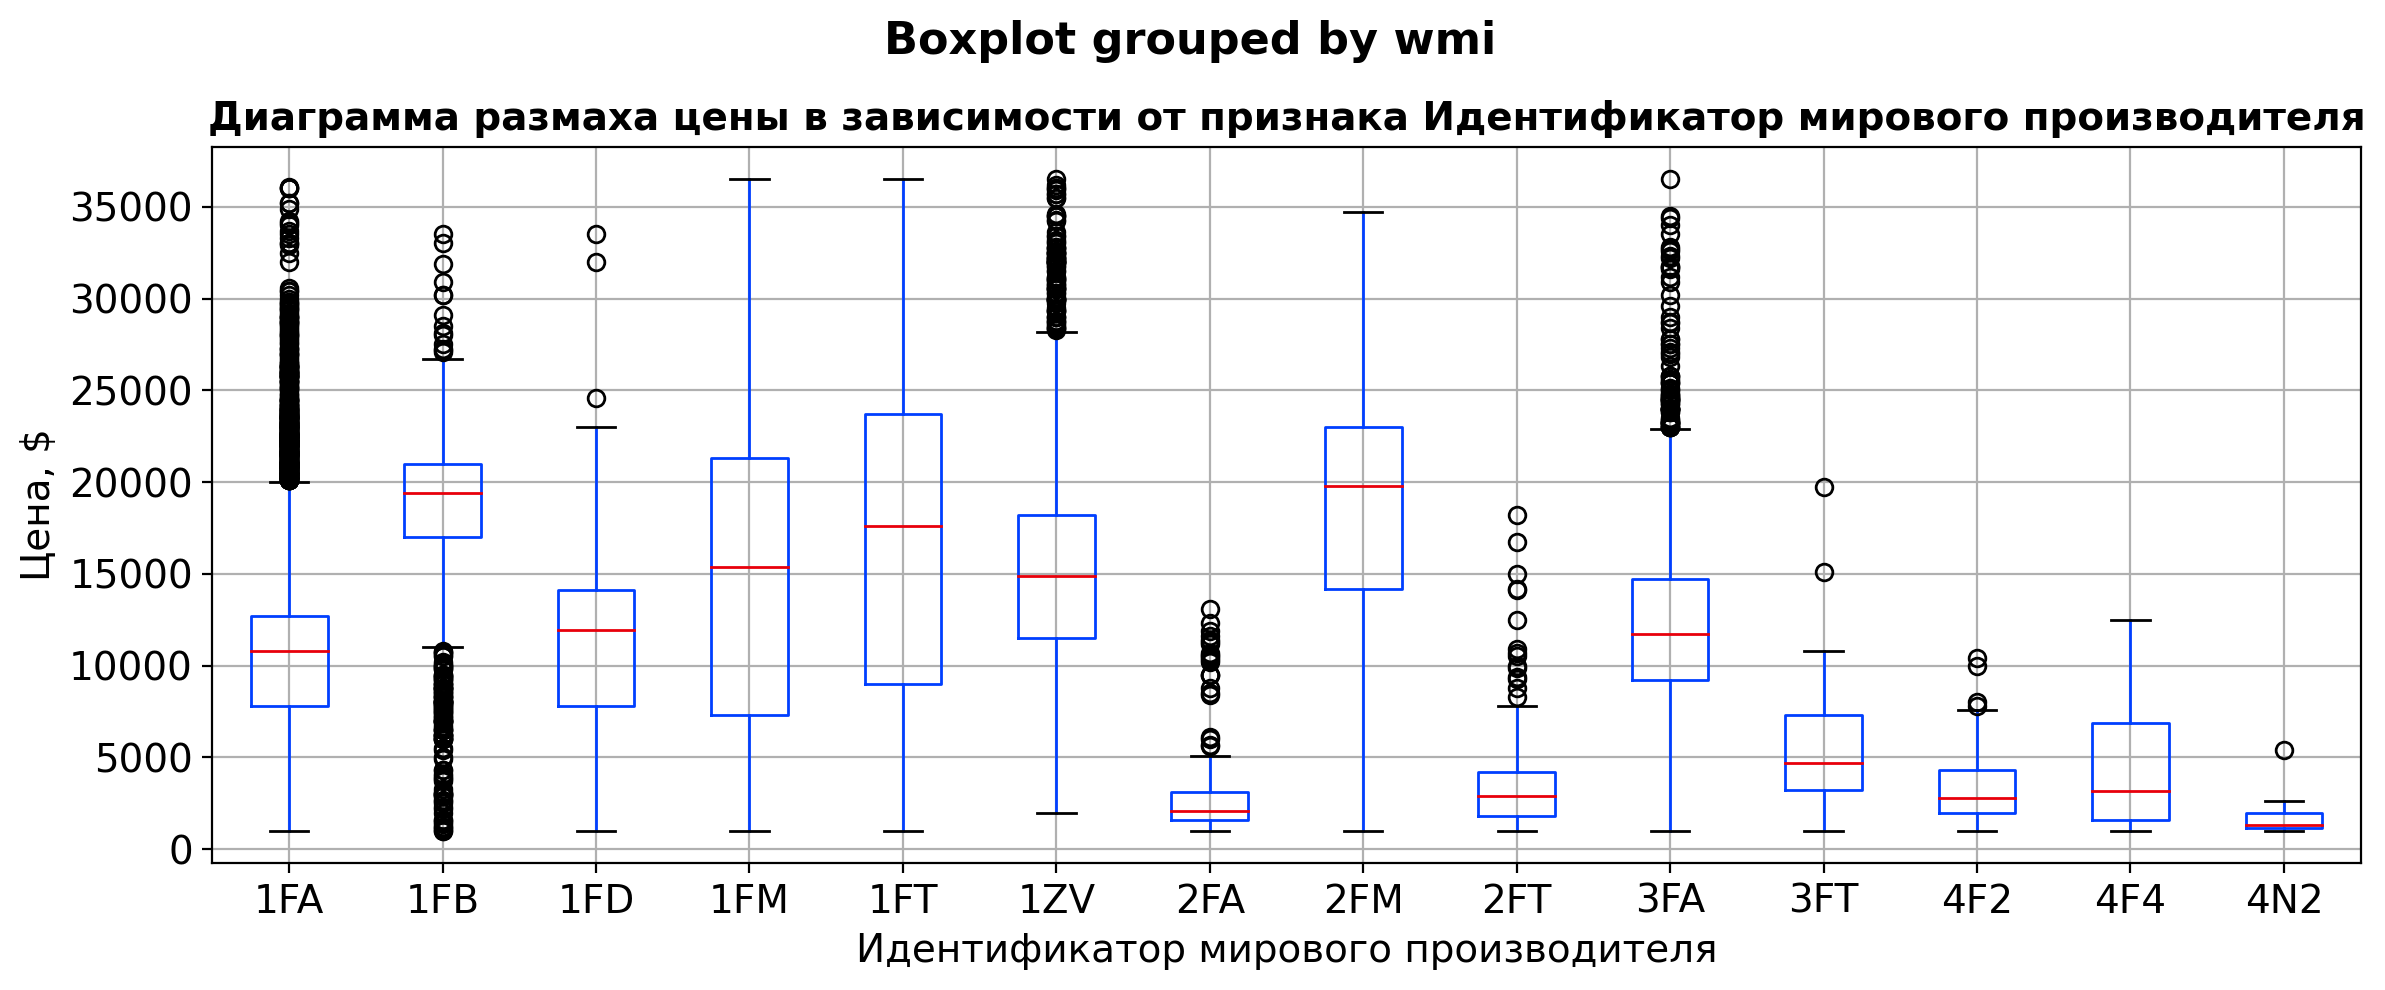

In [27]:
# вызов функции для построения диаграмм размаха цены, исходя из признака 'wmi'
build_boxplot('Идентификатор мирового производителя', 'wmi')

Первая цифра в `WMI` соответствует региону выпуска:
1, 4, 5 - США
2 - Канада
3 - Мексика
7F-70 - США.
Таким образом, согласно столбчатой диаграмме в датасете большинство автомобилей выпущенных в США: в топ-3 по количеству автомобилей (1FM, 1FT и 1FA) все выпущены в США.
Большинство автомобилей (18347 шт.) 1FM - это Ford MPV/SUV. Следующий по популярности - это 1FT (Ford truck). Их 17177.

Диаграммы размаха показывают, что стоимость автомобиля существенно зависит от WMI.
По цене наиболее высокими по медианному значению являются автомобили 2FM, 1FB, 1FT и 1FM. Их стоимость выше 15000. Самым дешевым является 4N2.

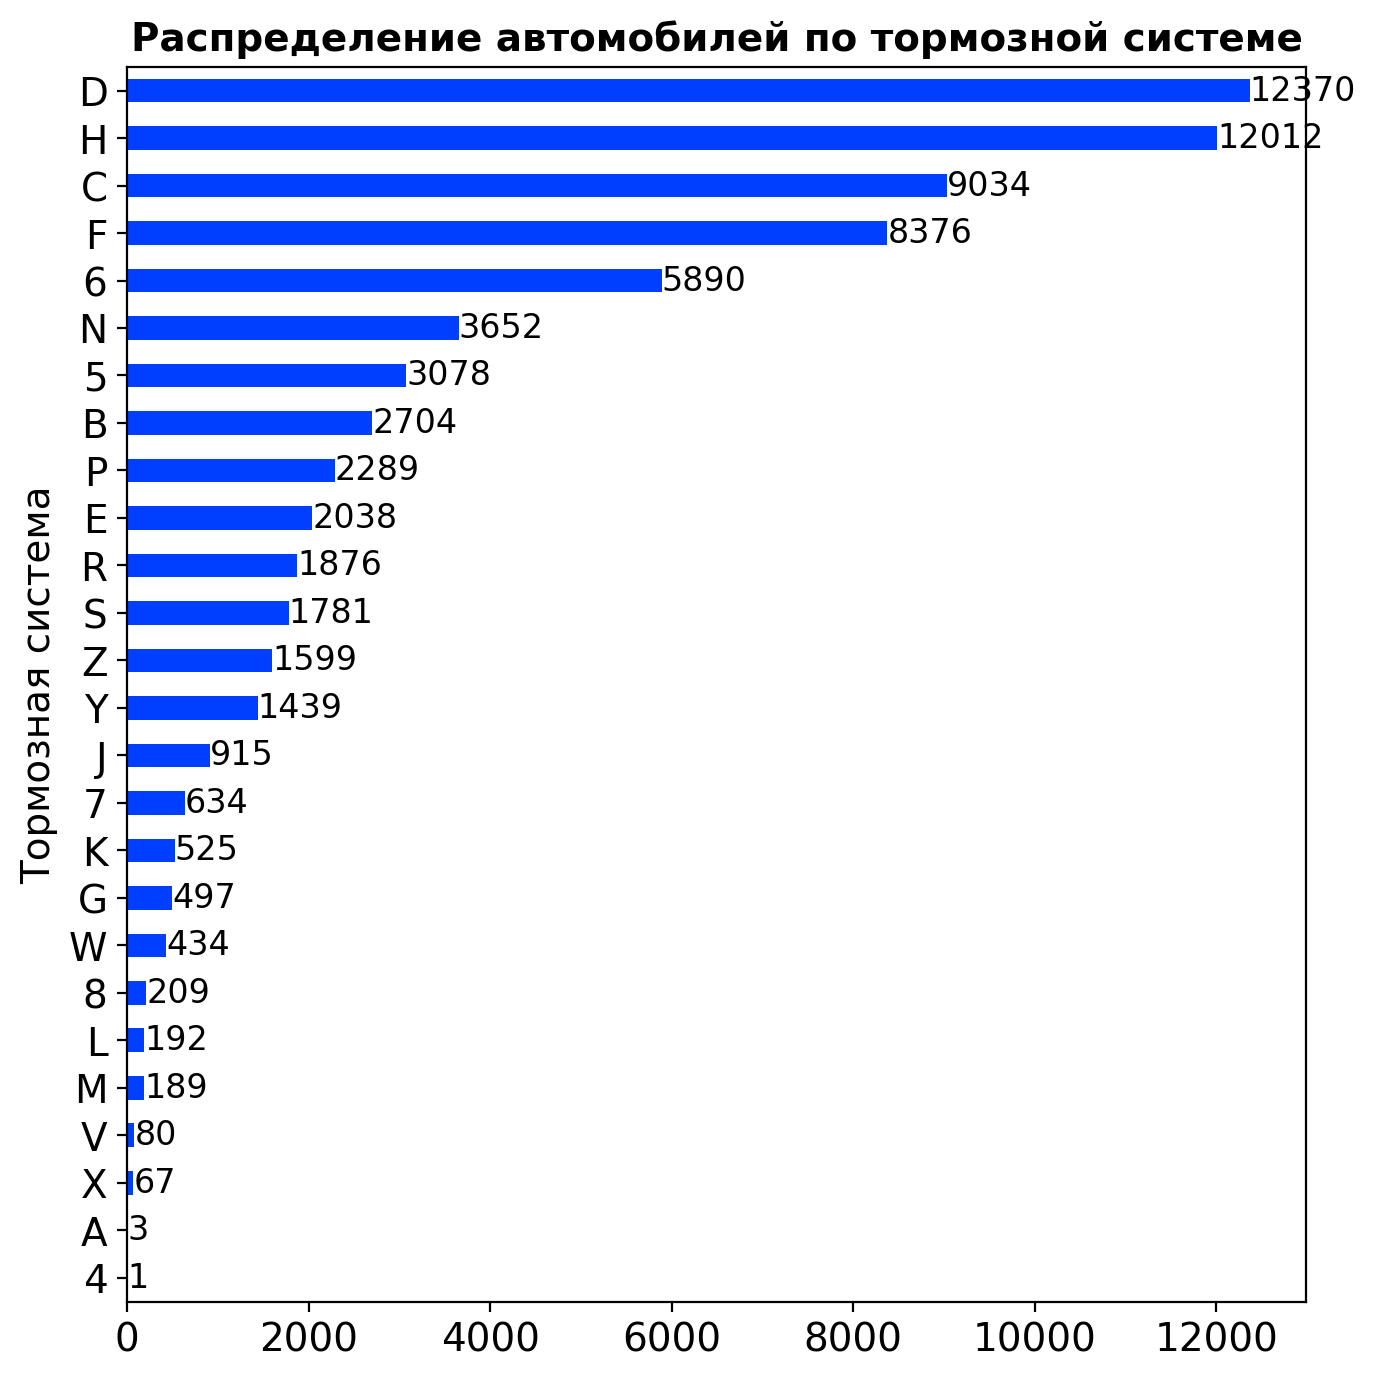

In [28]:
# вызов функции для построения горизонтальной столбчатой диаграммы
disc_plot('brake', 'Распределение автомобилей по тормозной системе', 'Тормозная система')

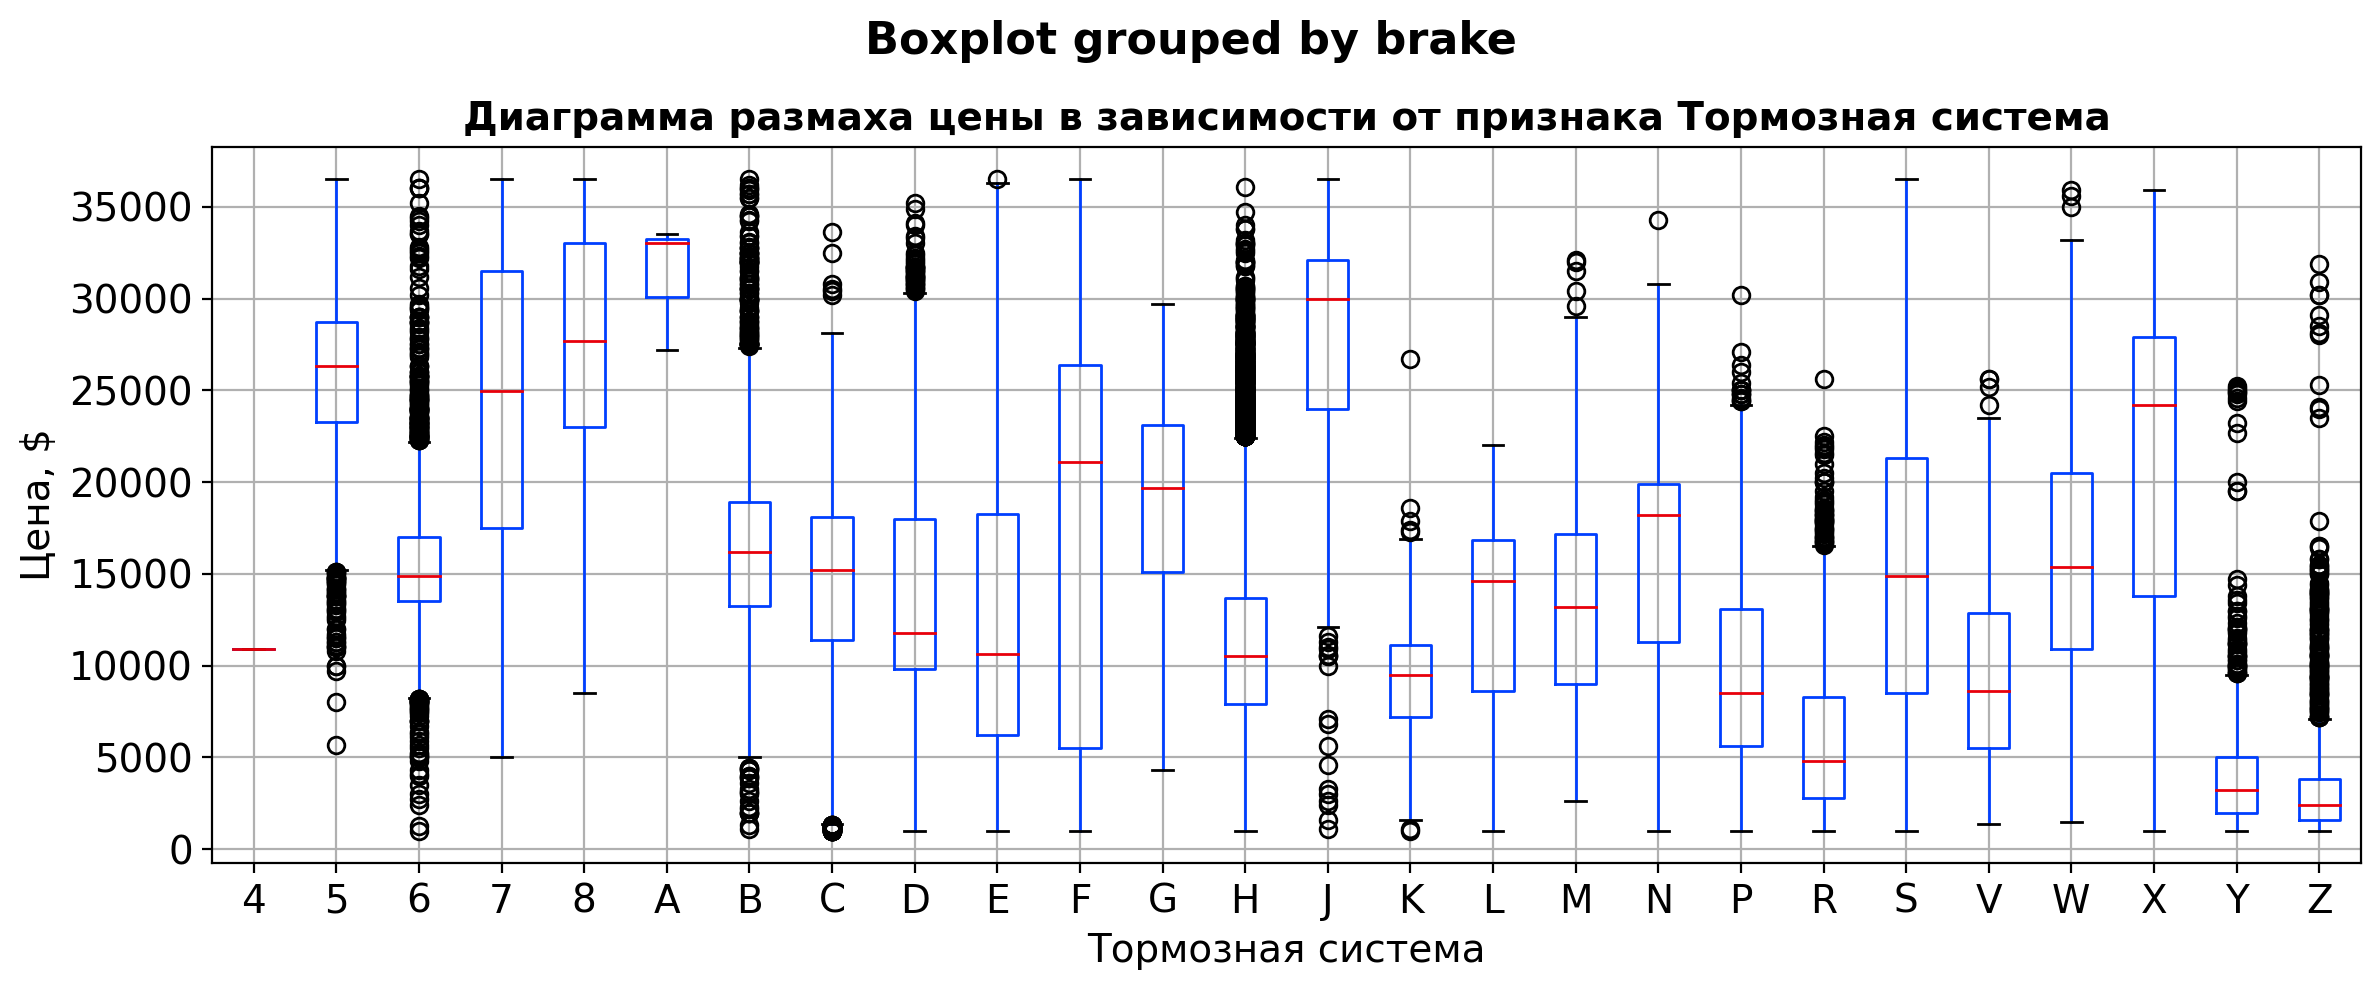

In [29]:
# вызов функции для построения диаграмм размаха цены, исходя из признака 'brake'
build_boxplot('Тормозная система', 'brake')

Признак `brake` также заметно влияет на стоимость автомобиля.

Проверим сколько уникальных значений в столбце `model`.

In [30]:
# просмотр количества уникальных значений признака 'model'
car_data['model'].value_counts()

model
P0H    6171
P3F    3931
W1E    3897
P3K    1958
P0J    1487
       ... 
R2Y       1
X15       1
K30       1
P7A       1
F25       1
Name: count, Length: 365, dtype: int64

In [31]:
# просмотр моделей, встречающихся более 50 раз
popular_models = car_data['model'].value_counts().where(lambda x : x>50).dropna()
popular_models

model
P0H    6171.0
P3F    3931.0
W1E    3897.0
P3K    1958.0
P0J    1487.0
        ...  
P2J      54.0
P45      53.0
U20      52.0
Z04      52.0
P74      51.0
Name: count, Length: 176, dtype: float64

In [32]:
# укрупнение группы путём объединения редких моделей в категорию rare
car_data['model_group'] = (
    car_data['model']
    .where(car_data['model'].isin(popular_models.index), 'rare')
)
car_data['model_group'].value_counts()

model_group
P0H     6171
P3F     3931
W1E     3897
rare    2839
P3K     1958
        ... 
P2J       54
P45       53
U20       52
Z04       52
P74       51
Name: count, Length: 177, dtype: int64

Объединили модели, встречающиеся в датасете менее 50 раз в категорию rare. В итоге получилось 177 уникальных значений.

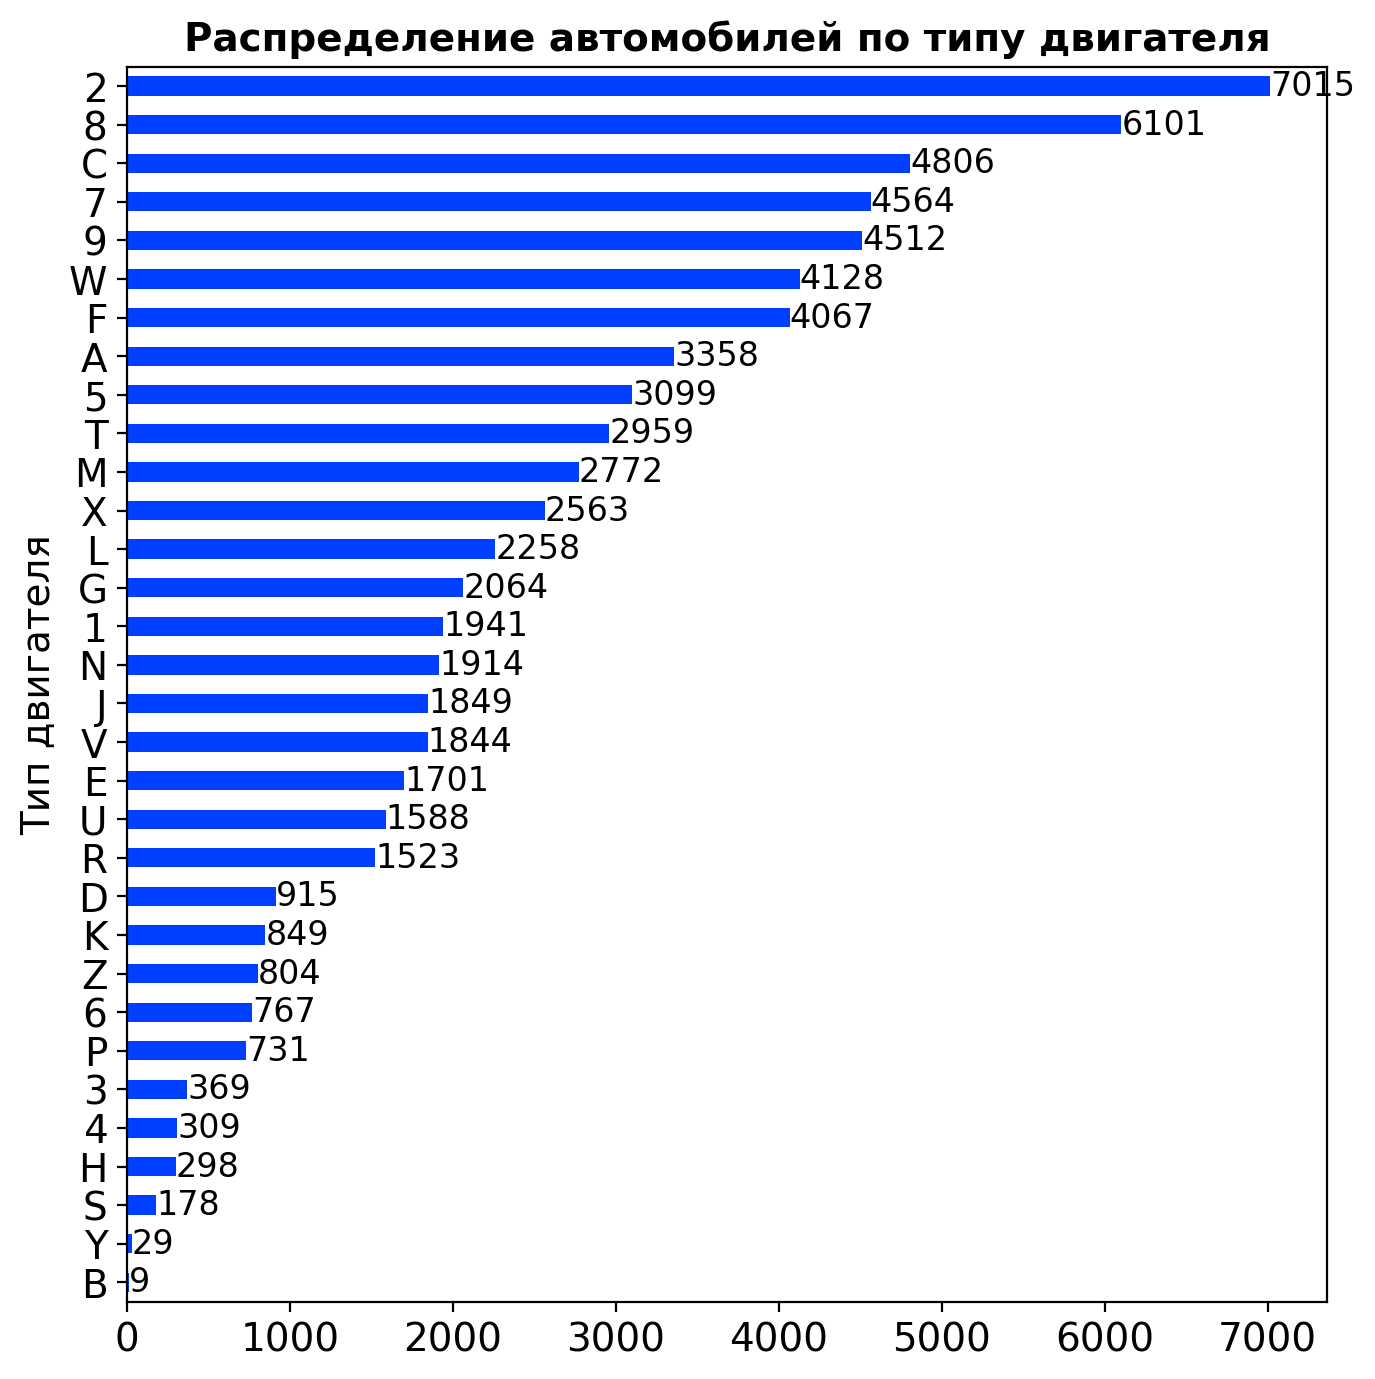

In [33]:
# вызов функции для построения горизонтальной столбчатой диаграммы
disc_plot('engine', 'Распределение автомобилей по типу двигателя', 'Тип двигателя')

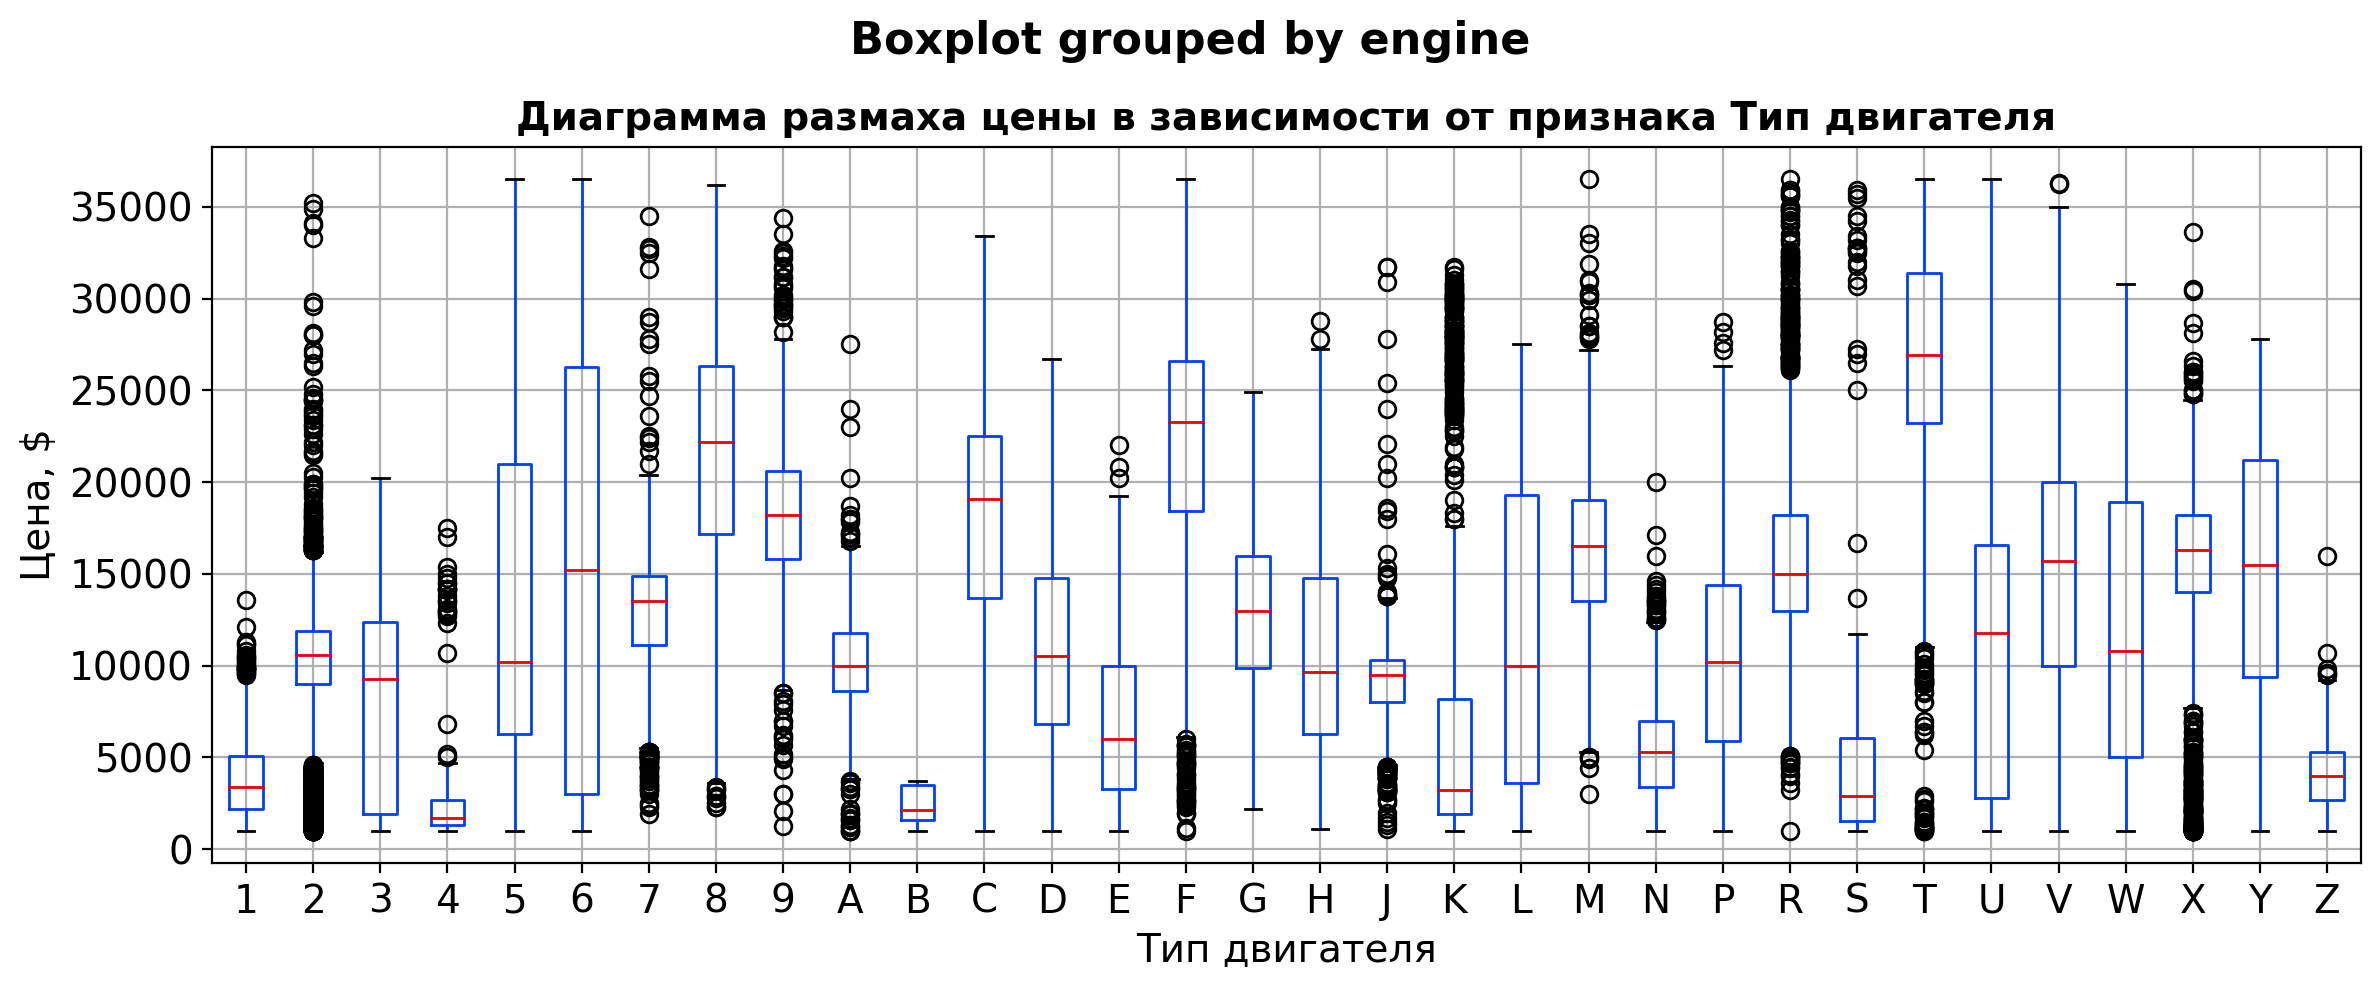

In [34]:
# вызов функции для построения диаграмм размаха цены, исходя из признака 'engine'
build_boxplot('Тип двигателя', 'engine')

По диаграмме размаха наблюдается сильное изменение диапазона цен в зависимости от типа двигателя. Можно ожидать, что этот признак будет иметь хорошую корреляционную связь с целевым признаком.

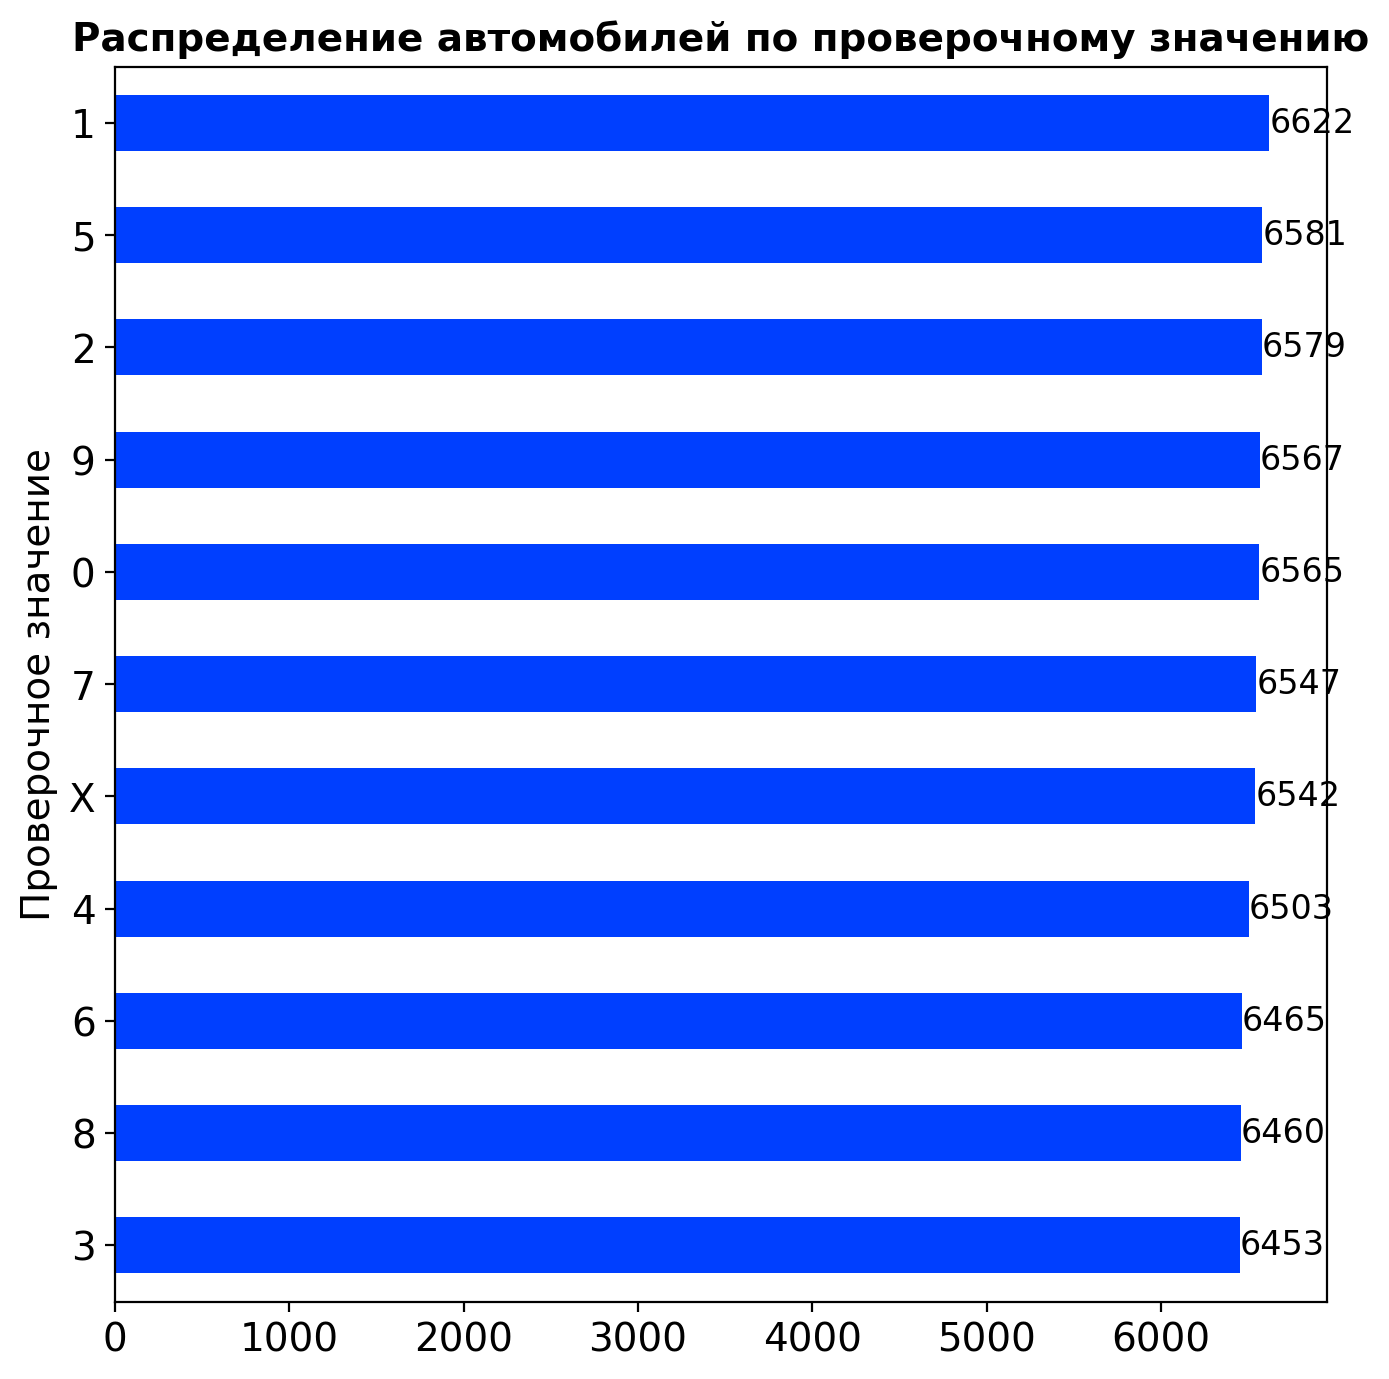

In [35]:
# вызов функции для построения горизонтальной столбчатой диаграммы
disc_plot('check', 'Распределение автомобилей по проверочному значению', 'Проверочное значение')

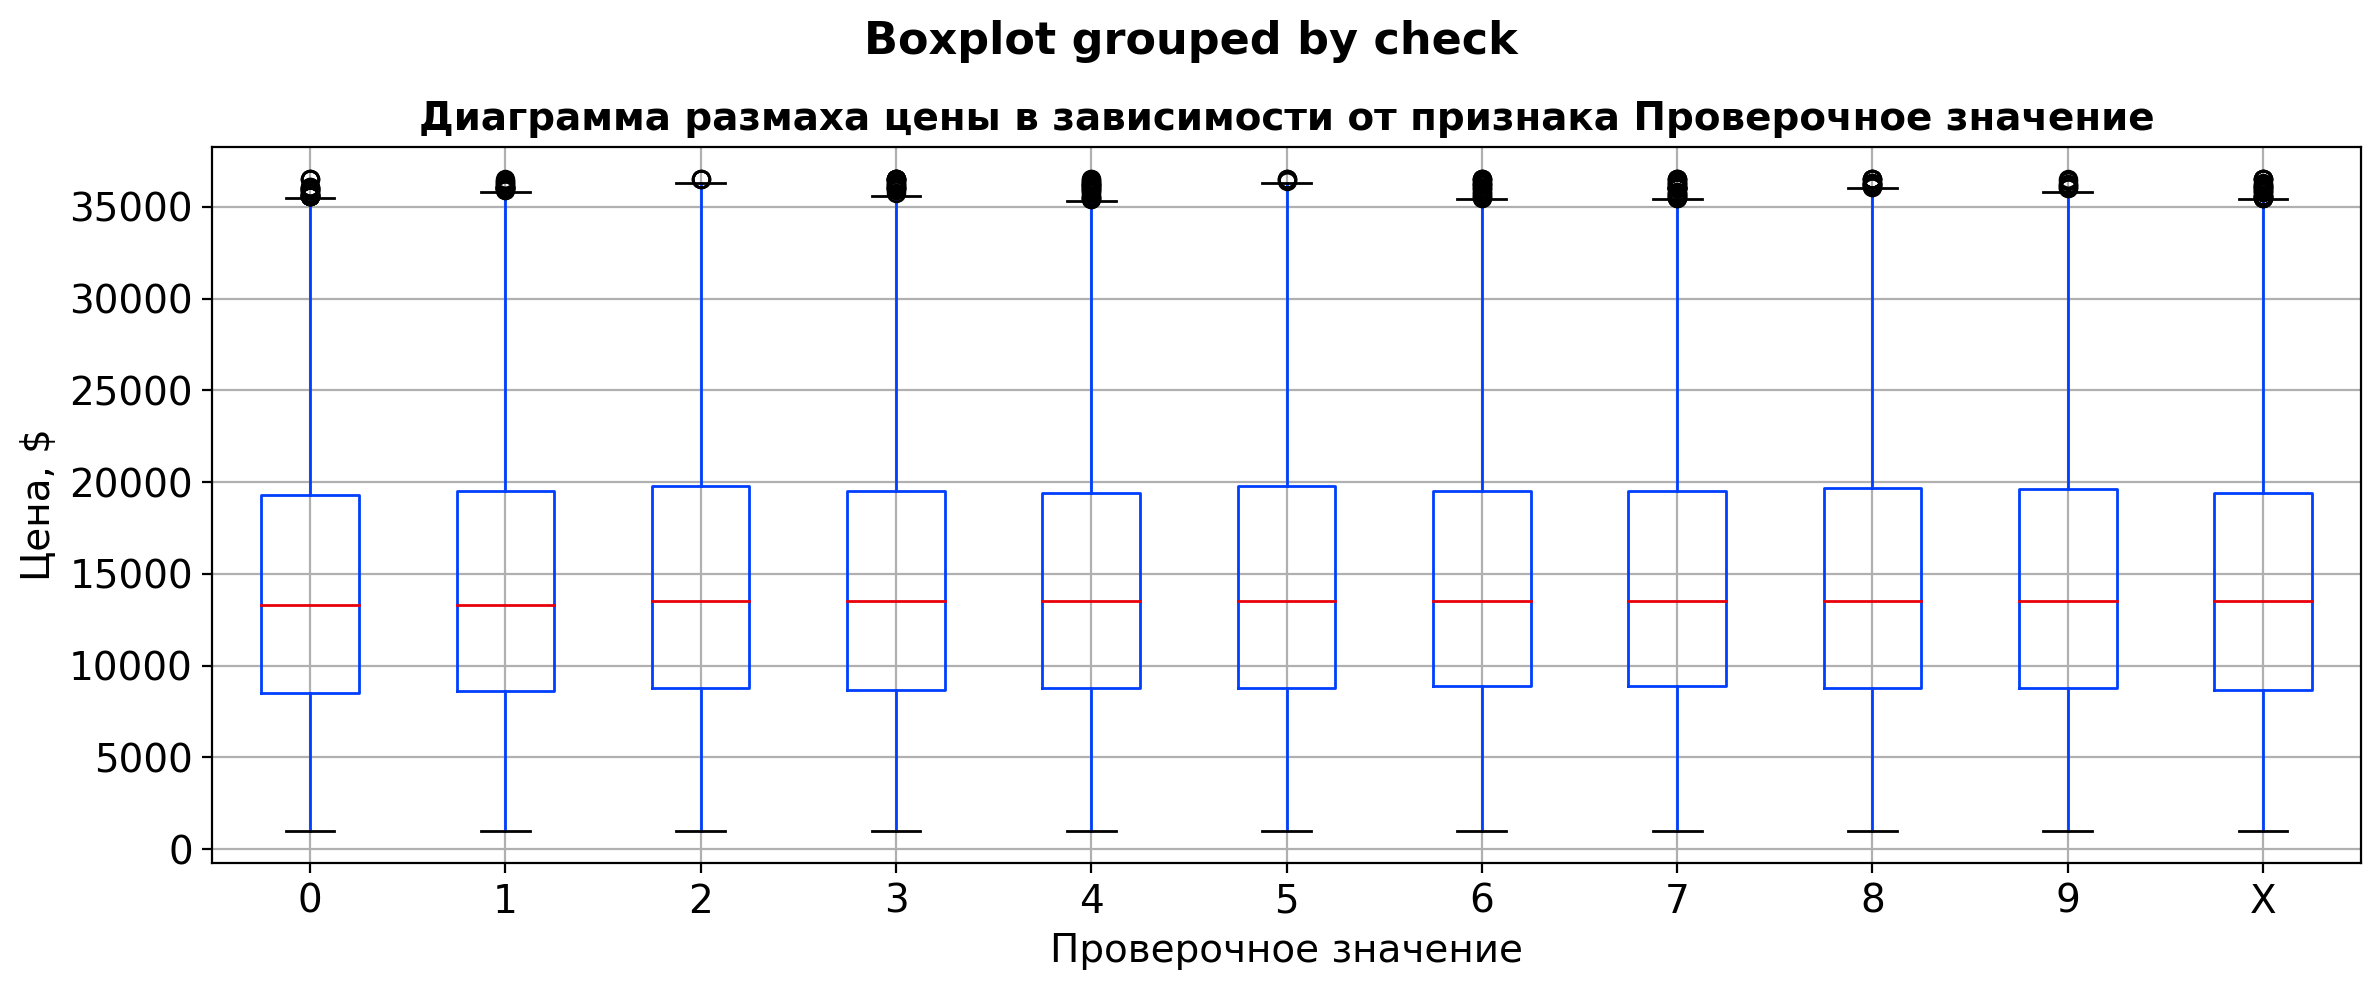

In [36]:
# вызов функции для построения диаграмм размаха цены, исходя из признака 'check'
build_boxplot('Проверочное значение', 'check')

По полученным графикам видно, что признак `check`, содержащий проверочное значение является неинформативным для прогнозирования стоимости автомобиля, поэтому его можно удалить.

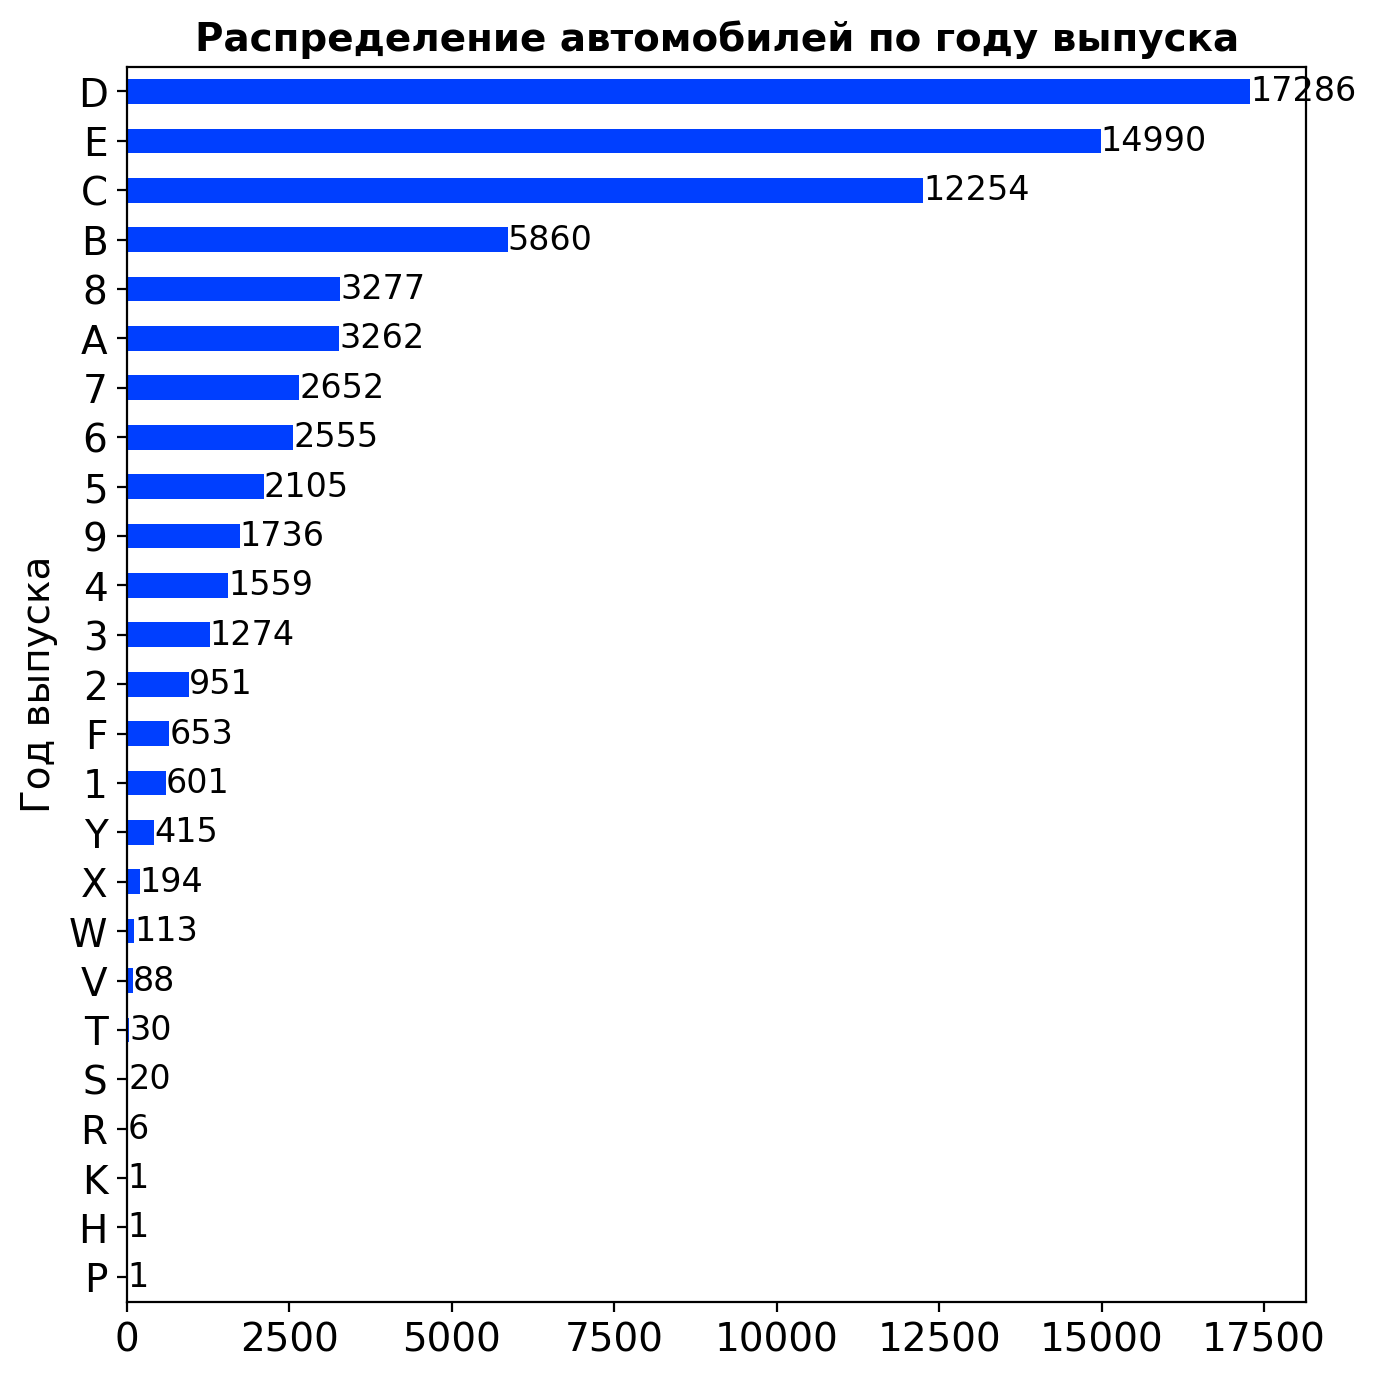

In [37]:
# вызов функции для построения горизонтальной столбчатой диаграммы
disc_plot('year', 'Распределение автомобилей по году выпуска', 'Год выпуска')

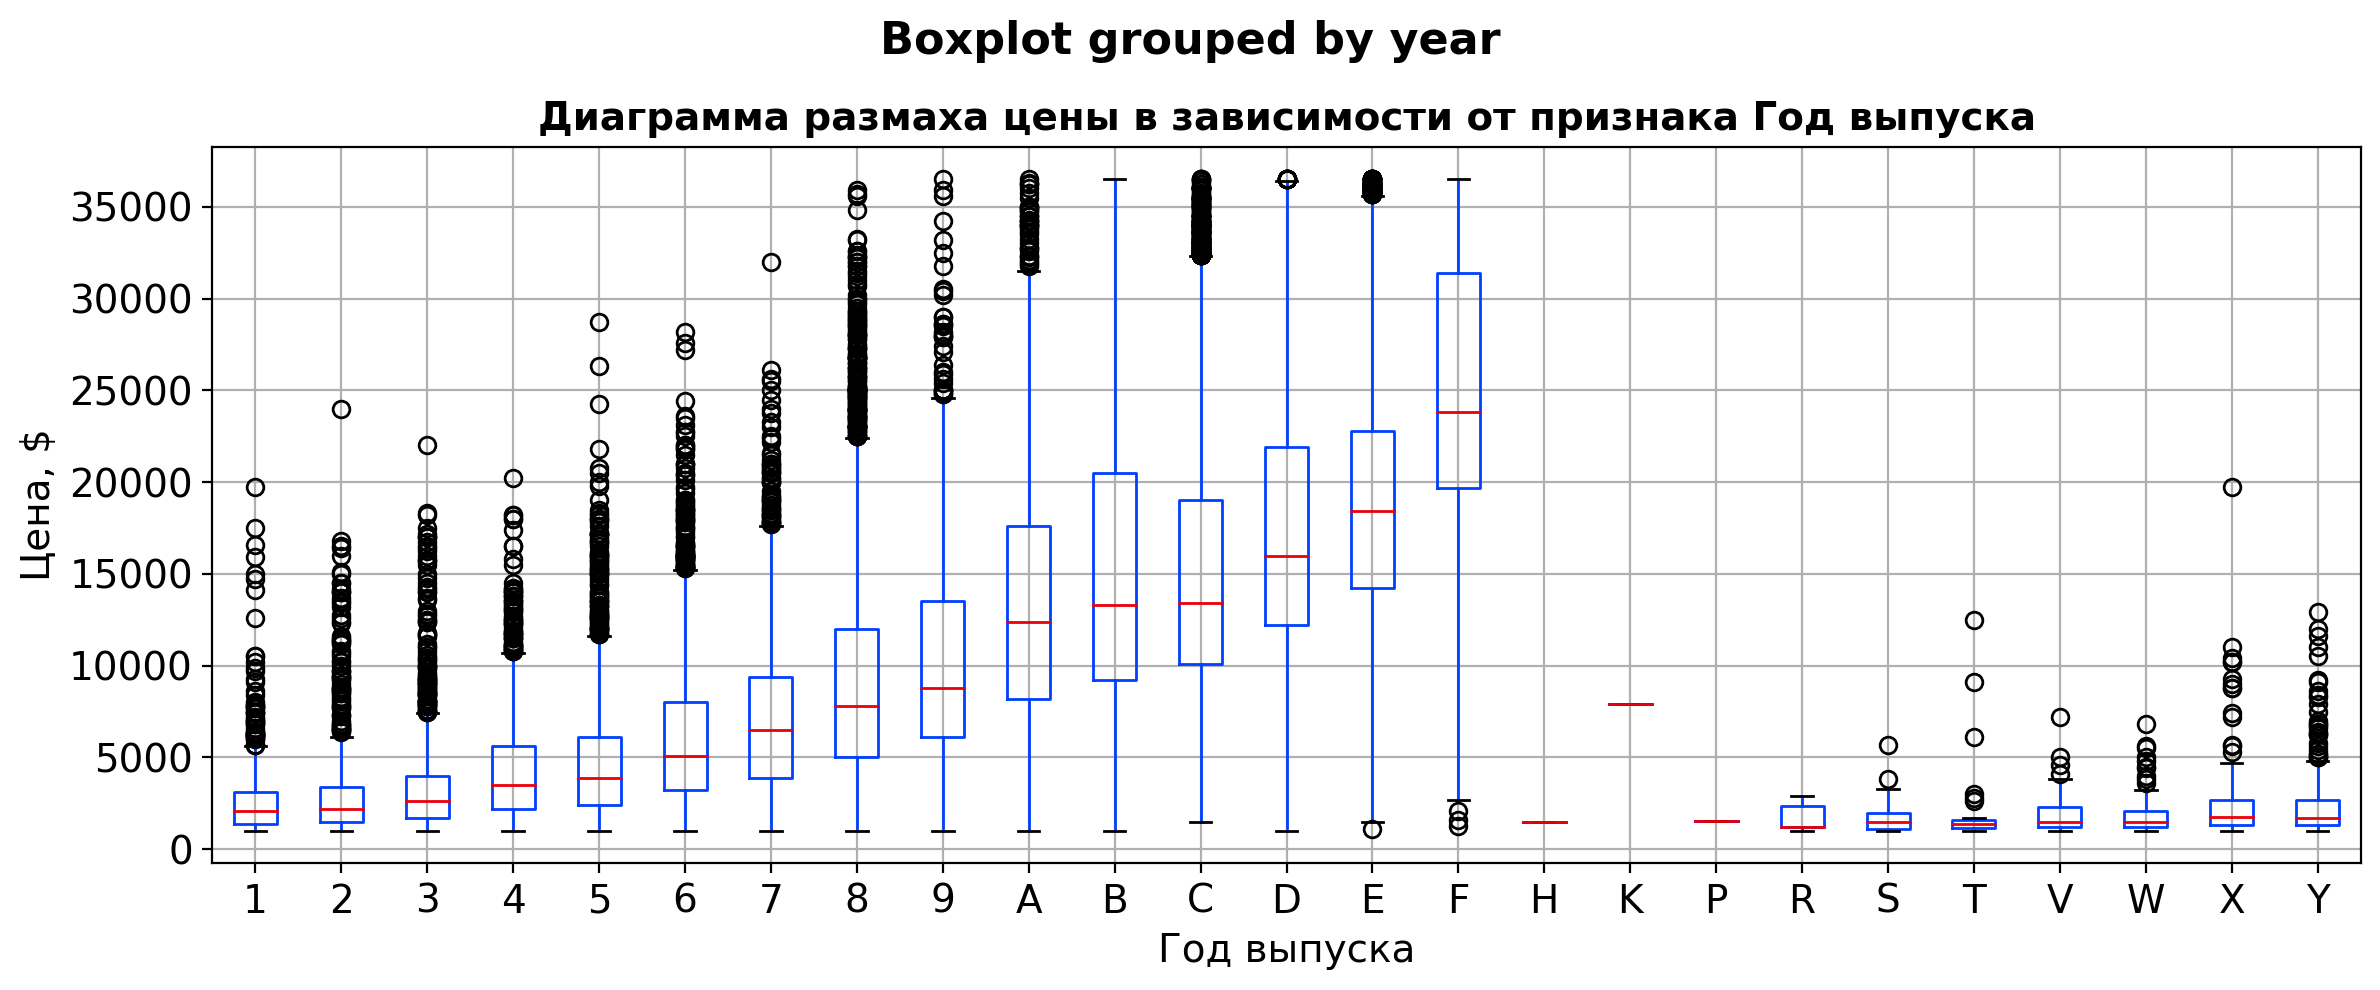

In [38]:
# вызов функции для построения диаграмм размаха цены, исходя из признака 'year'
build_boxplot('Год выпуска', 'year')

Большинство автомобилей в датасете имеют кодировку года выпуска `D`, что соответствует 1983 или 2013 году выпуска.

По диаграмме размаха наблюдается последовательное увеличение стоимости от года с кодировкой `1` до `F`. Код `1` соответствует 2001 и 2031 годам; в данном случае имеется ввиду 2001. Код `F` - 1985 или 2015. Можно предположить, что имеющийся датасет актуален на 2015 год и поэтому наиболее дорогими являются автомобили выпущенные в этот год.

В данных имеется по одному автомобилю, выпущенному в году с кодировкой `H`, `K` и `P`.

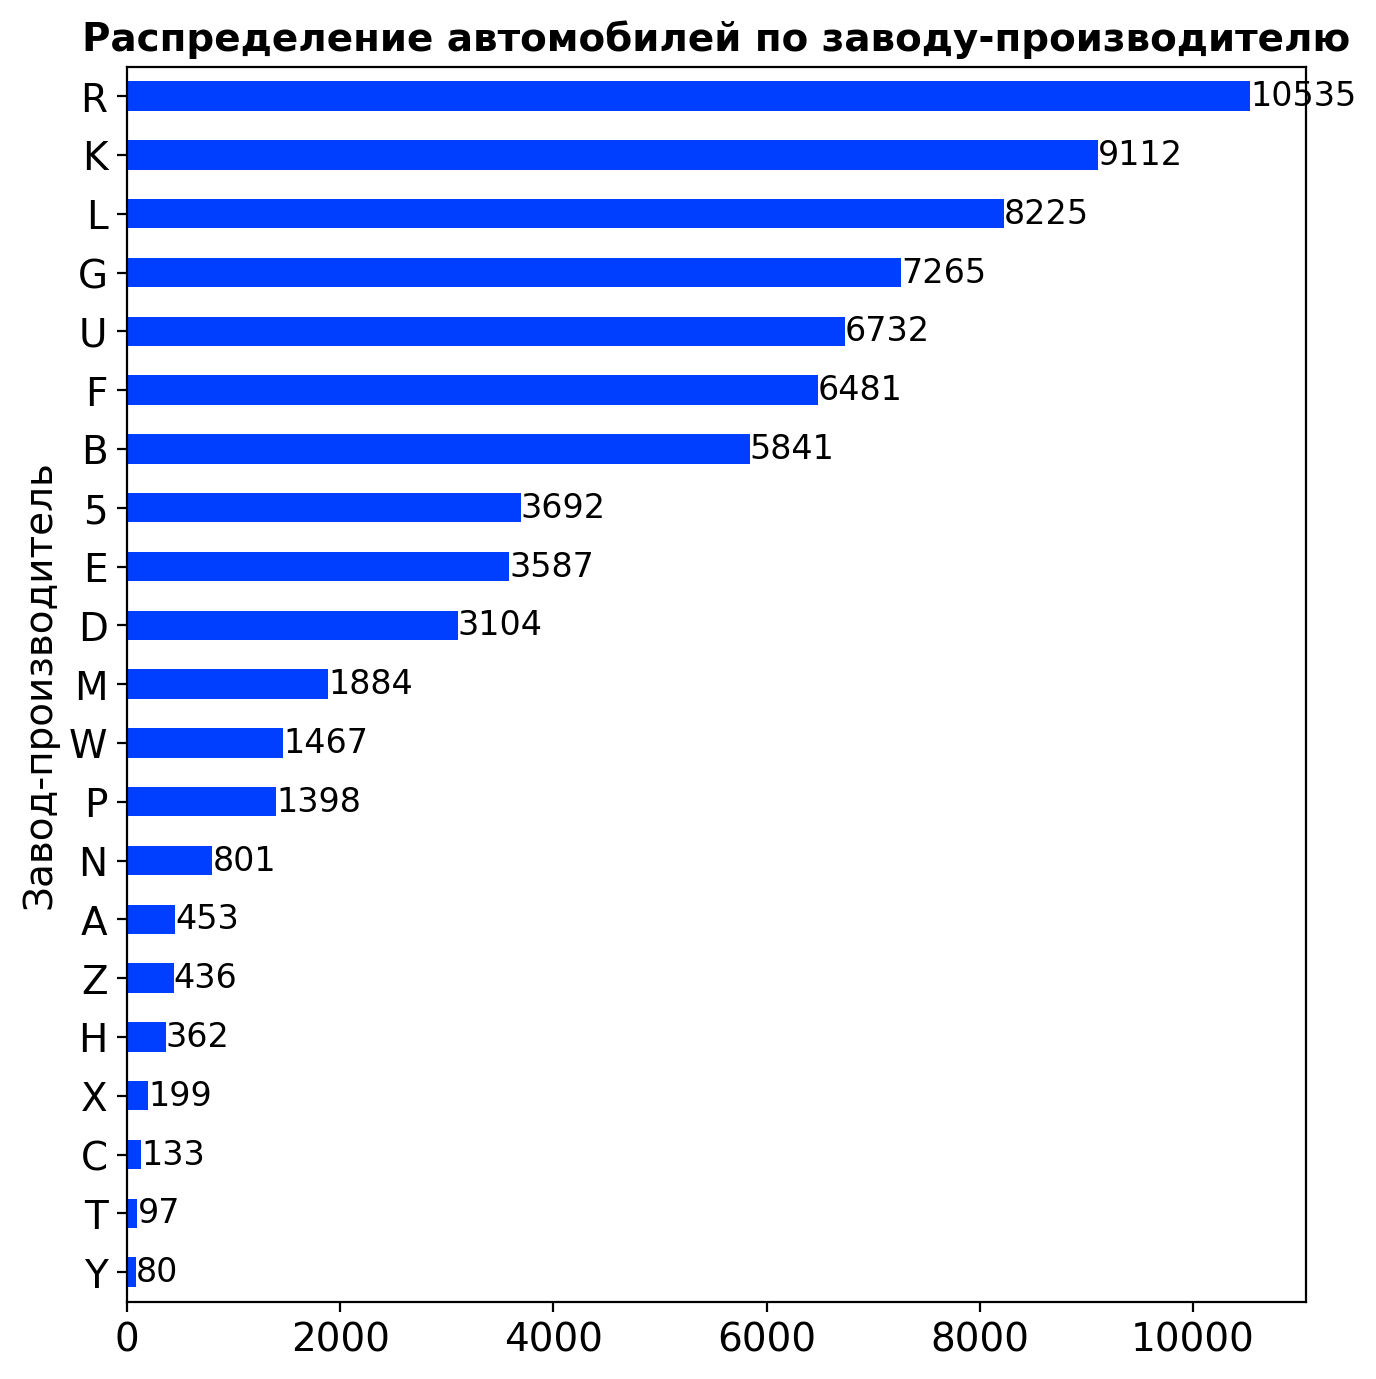

In [39]:
# вызов функции для построения горизонтальной столбчатой диаграммы
disc_plot('plant', 'Распределение автомобилей по заводу-производителю', 'Завод-производитель')

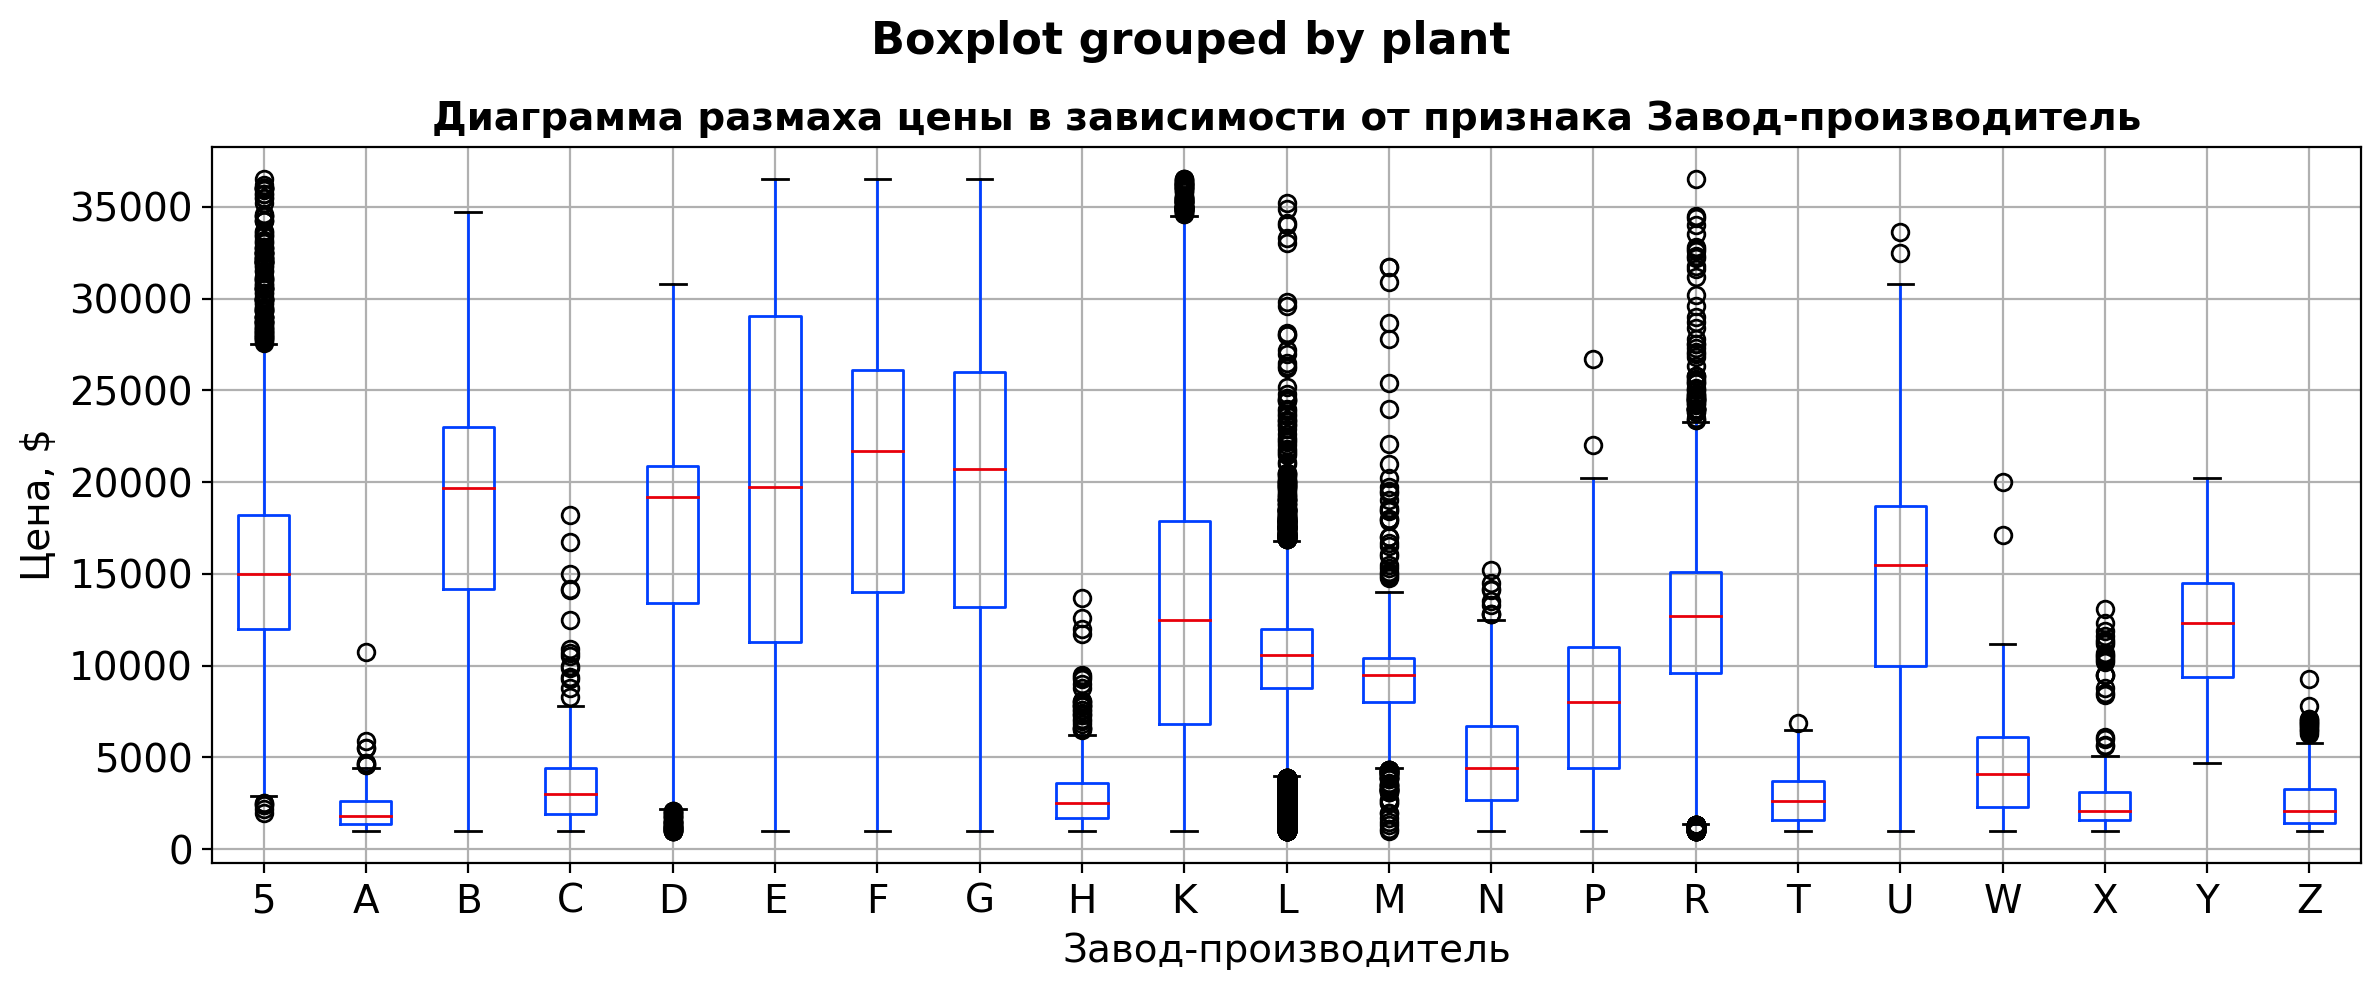

In [40]:
# вызов функции для построения диаграмм размаха цены, исходя из признака 'plant'
build_boxplot('Завод-производитель', 'plant')

Признак `plant` (Завод-производитель) оказывает существенное значение на уровень цен на автомобиль.

In [41]:
car_data['serial_num'].value_counts()

serial_num
B55197    4
A55835    3
A64225    3
A65672    3
A68405    3
         ..
103070    1
298177    1
190661    1
A73505    1
D21749    1
Name: count, Length: 68215, dtype: int64

Признак `serial_num` содержит большое количество (68215) уникальных значений. Кроме того, данный признак не несет важной информации о стоимости автомобиля, поэтому не будет использоваться в моделировании.

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между признаками разных типов данных. Для этого используем библиотеку phik.

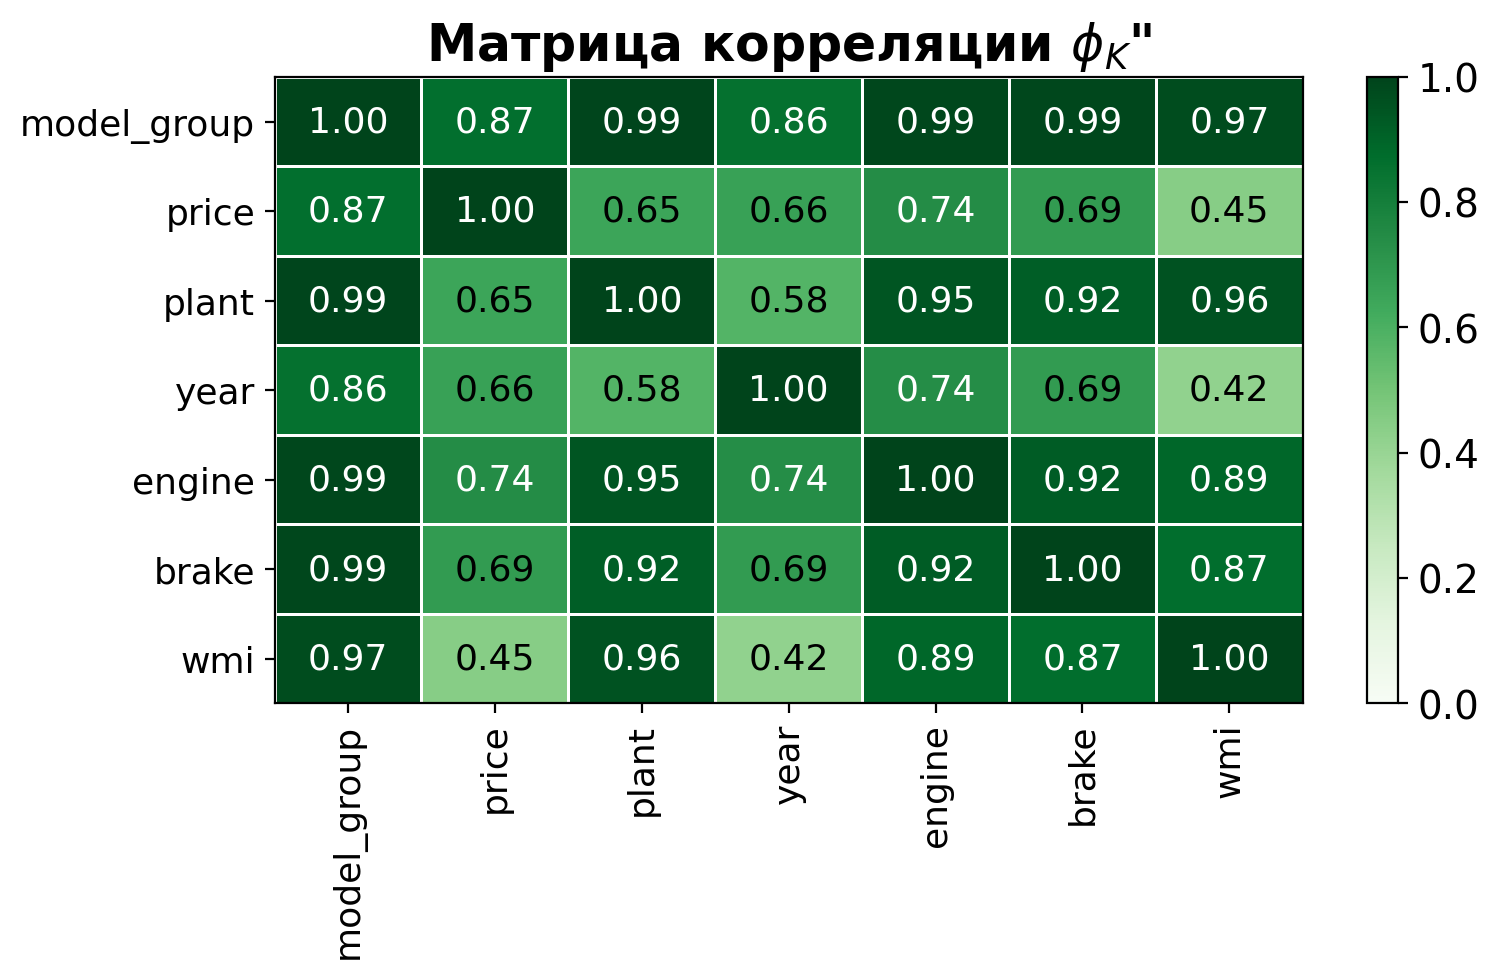

In [42]:
temp = car_data.copy()
temp = temp.drop(['model', 'serial_num', 'check'], axis=1)
# создаём список с наименованиями непрерывных признаков
interval_cols = ['price']

# считаем коэффициенты корреляции
phik_overview= phik_matrix(temp, interval_cols=interval_cols)

# строим матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$"',
    fontsize_factor=1.3,
    figsize=(8, 5)
)
plt.show()


По матрице корреляции видно, что признак `model_group`, содержащий информацию  о марке, серии и типе кузова мультиколлинеарен признакам `plant`, `engine`, `brake` и `wmi`, поэтому его необходимо удалить, чтобы избежать утечки. Кроме того, признаки `plant` - `wmi`, `plant` - `engine` также характеризуются очень сильной взаимосвязью.

## Обучение модели

Протестируем 3 модели: LinearRegression, CatBoostRegressor и LightGBM.

Для модели CatBoostRegressor нет необходимости кодировать категориальные признаки и масштабировать численные, поэтому для нее будем подавать "сырые" данные. Для остальных же моделей воспользуемся OneHotEncoder для категориальных признаков. Все входные признаки категориальные.

In [43]:
# список столбцов с категориальными признаками
cat_columns = ['wmi', 'brake', 'engine', 'year', 'plant']

In [44]:
# записываем входные данные в переменную Х, целевой признак в переменную у
X = car_data.drop(['price', 'model', 'serial_num', 'model_group', 'check'], axis=1)
y = car_data['price']

# делим выборку на тренировочную и тестовую со статификацией по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

print(f"Размер обучающей выборки: {X_train.shape}, тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (53913, 5), тестовой выборки: (17971, 5)


Разбили исходный датасет в соотношении train/test 3:1.

In [45]:
# создание пустого списка для добавления лучших метрик по всем лучшим моделям
rmse_cv = []

def prep_model_pipe(model, params):
    '''
    Функция, которая подготавливает признаки, производит подбор гиперпараметров и
    возвращает лучшую модель
    '''
    # соберём пайплайн подготовки данных
    # SimpleImputer + OHE
    ohe_pipe = Pipeline([
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ])

    data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns)
    ],
    remainder='passthrough'
)


    # финальный пайплайн
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('clf', model),
    ])

    gs = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    # запуск поискa  лучших гиперпараметров
    gs.fit(X_train, y_train)

    print('Параметры лучшей модели:\n\n', gs.best_estimator_)

    rmse_cv.append(gs.best_score_ * (-1))

    return gs.best_estimator_

### Модель LinearRegression

In [46]:
# словарь с параметрами для LinearRegression
lr_params = {'clf__fit_intercept': [True, False]
            }

# инициализируем модель LinearRegression
model_lr = LinearRegression()

# вызов функции с подготовкой признаков и подбором гиперпараметров для LinearRegression
model_lr = prep_model_pipe(model_lr, lr_params)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['wmi', 'brake', 'engine',
                                                   'year', 'plant'])])),
                ('clf', LinearRegression())])


### Модель LightGBM

In [47]:
# словарь с параметрами для LightGBM моделирования
params_lgbm = {'clf__learning_rate': [0.05],
          'clf__n_estimators': [100, 150],
          'clf__num_leaves': [25, 35]
}

# инициализируем модель LGBMRegressor
model_lgbm = lgb.LGBMRegressor(objective='regression',
                               random_state=RANDOM_STATE)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для LGBM
model_lr = prep_model_pipe(model_lgbm, params_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 53913, number of used features: 103
[LightGBM] [Info] Start training from score 14301.536568
Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
    

### Модель CatBoostRegressor

In [48]:
# словарь с параметрами для CatBoost()
cat_params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [4, 8]
    }

# инициализируем модель CatBoostRegressor()
model_cat = CatBoostRegressor(iterations=200,
                              loss_function='RMSE',
                              verbose=False)

# подбор гиперпараметров для CatBoostRegressor()
gs = model_cat.grid_search(cat_params,
                           Pool(X_train, y_train, cat_features=cat_columns),
                           cv=3)

rmse_cv.append(np.min(gs['cv_results']['test-RMSE-mean']))

# среднее значение RMSE
print(f"RMSE на кросс-валидации: {np.min(gs['cv_results']['test-RMSE-mean']):.2f}")

print('Параметры лучшей модели:\n\n', gs['params'])


bestTest = 4549.891812
bestIteration = 199

0:	loss: 4549.8918120	best: 4549.8918120 (0)	total: 4.78s	remaining: 14.4s

bestTest = 3097.302119
bestIteration = 199

1:	loss: 3097.3021193	best: 3097.3021193 (1)	total: 7.75s	remaining: 7.75s

bestTest = 4285.383994
bestIteration = 199

2:	loss: 4285.3839938	best: 3097.3021193 (1)	total: 16.3s	remaining: 5.44s

bestTest = 3033.740529
bestIteration = 199

3:	loss: 3033.7405294	best: 3033.7405294 (3)	total: 23.7s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 3081.220421
bestIteration = 199

Training on fold [1/3]

bestTest = 3088.966231
bestIteration = 199

Training on fold [2/3]

bestTest = 3064.08731
bestIteration = 199

RMSE на кросс-валидации: 3078.09
Параметры лучшей модели:

 {'depth': 8, 'learning_rate': 0.1}


## Тестирование

Соберем все метрики RMSE, оцененные на кросс-валидации по всем моделям в датафрейм.

In [49]:
result = pd.DataFrame(
    {
    "Модель": ['LinearRegression', 'LightGBM', 'CatBoostRegressor'],
    "RMSE на cv": rmse_cv
    }
)
result

,Модель,RMSE на cv
0,LinearRegression,3325.270039
1,LightGBM,3110.286714
2,CatBoostRegressor,3078.091321


По результатам кросс-валидации лучшей оказалась модель CatBoostRegressor. Ее метрика RMSE равна 3084. Сделаем по ней прогнозы на тестовой выборке, чтобы оценить финальную метрику и чтобы проверить переобученность модели.

In [50]:
# рассчитаем прогноз и метрики на тестовых данных
y_test_pred = model_cat.predict(X_test)
rmse_test = mse(y_test, y_test_pred, squared=False)
print(f'Метрика RMSE на тестовой выборке: ${round(rmse_test, 2)}')

Метрика RMSE на тестовой выборке: $3081.04


Расчитаем метрику RMSE на dummy модели и сравним её с остальными моделями.

In [51]:
# создание и обучение модели DummyRegressor
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# расчет RMSE для модели DummyRegressor
rmse_dummy_test = mse(y_test, dummy_model_preds, squared=False)
print(f'Метрика RMSE на тестовой выборке дамми-модели: ${rmse_dummy_test:.2f}')

Метрика RMSE на тестовой выборке дамми-модели: $7876.13


Все модели продемонстрировали метрики лучше, чем показала константная модель.

### Анализ важности

Анализ важности признаков сделаем методом SHAP, который позволяет определить как каждый отдельный признак повлиял на результат.

In [52]:
# расчет SHAP значений для модели CatBoostClassifier
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer(X_test)

Посмотрим также на столбчатую диаграмму 'shap.plots.bar', которая показывает средние SHAP-значения по всем наблюдениям.

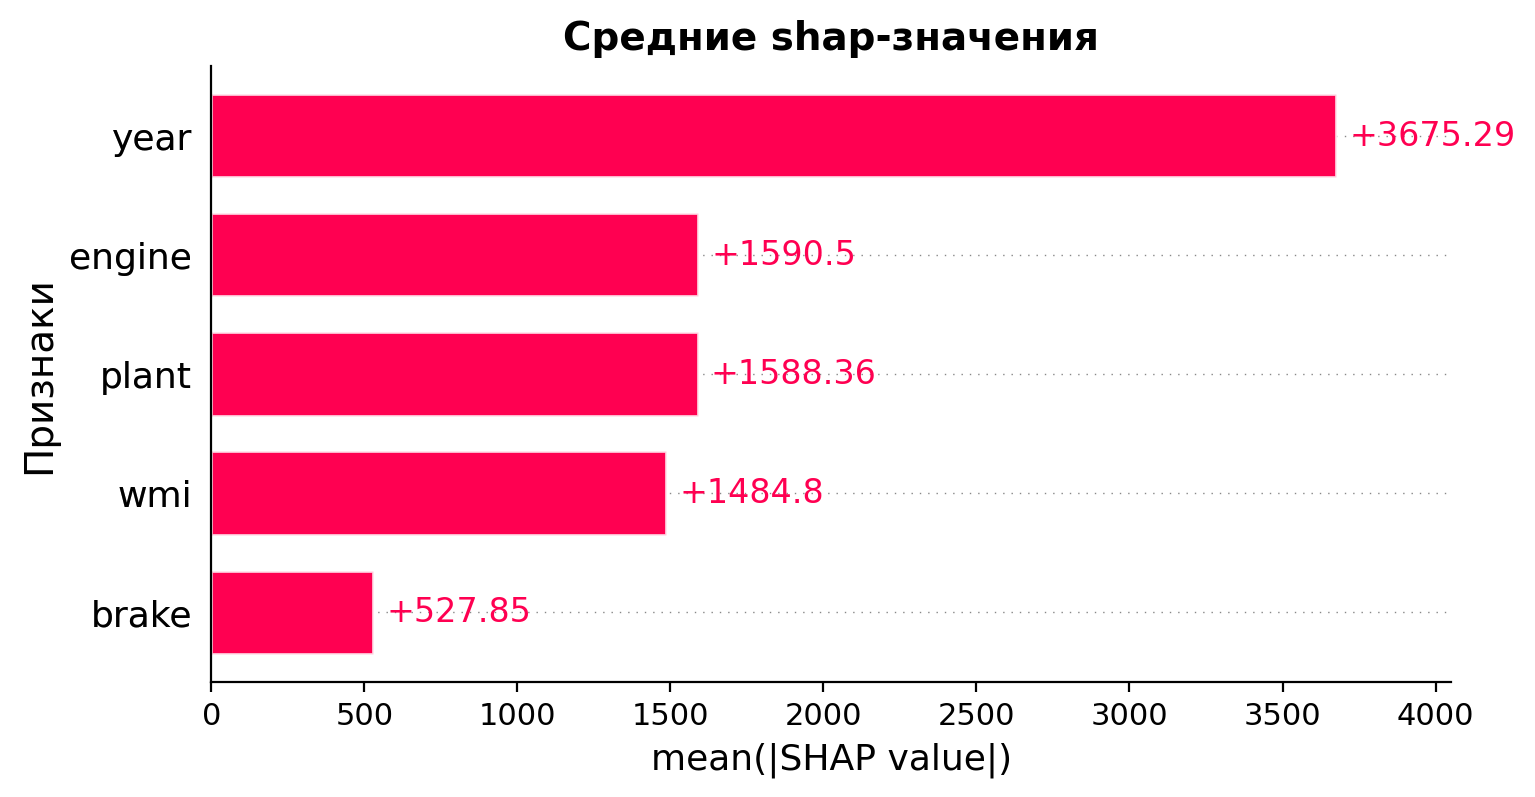

In [55]:
# построение столбчатой диаграммы средних SHAP-значений
plt.title('Средние shap-значения')
plt.ylabel('Признаки')
shap.plots.bar(shap_values, max_display=20)

Из полученной диаграммы следует, что самый большой вес у признака `year`, он сильнее всего влияет на прогнозы модели. Далее в топ-5 наиболее влияющих признаков по убыванию значимости:
- тип двигателя `engine`,
- завод-ппроизводитель `plant`,
- WMI
- тип тормозной системы `brake`.

## Вывод

В ходе данного проекта была разработана модель МО, которая наилучшим образом прогнозирует стоимость автомобиля, исходя из его VIN-кода.

В качестве исходных данных использовался txt-файл с VIN-кодом и стоимостью автомобиля.

На начальном этапе VIN-код был разложен на характеристики с помощью модуля re и, таким образом, был сформирован датафрейм со входными признаками:
- 'wmi' - World manufacturer identifier - Идентификатор мирового производителя;
- 'brake' - тормозная система;
- 'model' - используемая автомобильная платформа, модель и тип кузова;
- 'engine' - тип двигателя;
- 'check' - проверочное значение;
- 'year' - год выпуска;
- 'plant' - завод-производитель;
- 'serial_num' - идентификатор конкретного транспортного средства
- 'price' - цена (целевой признак).

В полученном датафрейме оказалось 71884 строк и 9 столбцов.

В ходе <u>исследовательского и корреляционного анализа</u> выяснилось, что признаки 'serial_num' и 'check' не содержат важной информации для предсказания цены. Признак 'model' мультиколлинеарен признакам 'plant', 'engine', 'brake' и 'wmi', поэтому его необходимо удалить, чтобы избежать утечки.

В итоге в качестве входных признаков использовались 5: 'wmi', 'brake', 'engine', 'year', 'plant'.

Все признаки, кроме целевого являются категориальными. Они были закодированы с помощью One-Hot-Encoder.

Были протестированы 3 модели: <u>LinearRegression, LightGBM и CatBoostRegressor</u>. Все модели продемонстрировали лучшую по сравнению с константной метрику. Наилучшую метрику RMSE на кросс-валидации показала модель CatBoostRegressor с параметрами {'depth': 8, 'learning_rate': 0.1}, RMSE = 3078. На тестовых данных она показала результат 3081.9.

Анализ важности признаков показал, что наиболее значимым является год выпуска.

Таким образом, этим проектом хотелось показать, что даже при минимальном наборе исходных данных можно создать модель МО.